# Deep Learning and Single-Cell Phenotyping for Rapid Antimicrobial Susceptibility Testing - Training Notebook

This notebook provides the necessary steps to set up the environment, download the dataset, and train the segmentation and classification models from the provided repository.

**Note:** Training deep learning models can be computationally intensive and may require a GPU runtime. Ensure you have selected a GPU runtime in Colab (Runtime -> Change runtime type -> GPU).

## 1. Clone the Repository

In [3]:
# Ensure the repo is available in the runtime
from pathlib import Path
import os

# Set `IC_REPO_URL` to your fork (recommended) so Colab clones your modified pipeline.
# Example:
#   %env IC_REPO_URL=https://github.com/<you>/Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing.git
DEFAULT_REPO_URL = "https://github.com/mitcysaraiva/ICproj.git"
REPO_URL = os.environ.get(
    "IC_REPO_URL",
    DEFAULT_REPO_URL,
)
CANDIDATE_REPO_DIRS = [
    ".",  # already in the repo root
    "Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing",
    "Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main",
]

repo_dir = None
for d in CANDIDATE_REPO_DIRS:
    if Path(d, "pipeline").exists():
        repo_dir = d
        break

if repo_dir is None:
    clone_dir = REPO_URL.rstrip('/').split('/')[-1]
    if clone_dir.endswith('.git'):
        clone_dir = clone_dir[:-4]
    repo_dir = clone_dir
    #!git clone --depth 1 {REPO_URL} {repo_dir}

# If the cloned repo doesn't have `pipeline/` at the top level, jump into the bundled upstream folder.
for candidate in (
    Path(repo_dir),
    Path(repo_dir) / "Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main",
    Path(repo_dir) / "Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing",
):
    if (candidate / "pipeline").exists():
        repo_dir = str(candidate)
        break

%cd {repo_dir}
print("Repo root:", Path.cwd())

/home/fertroll10/Documents/ICproj/ICproj/Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main
Repo root: /home/fertroll10/Documents/ICproj/ICproj/Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main


## 1.1 Compatibility patches (TensorFlow 2.x / NumPy 1.24+)

The upstream repo targets older TensorFlow/Numpy APIs. This cell patches a few small incompatibilities so it runs on modern Colab runtimes.

In [2]:
from pathlib import Path
import os
import sys

# Ensure we're running from the repo root (so relative paths like pipeline/... exist).
def _find_repo_root():
    here = Path.cwd()
    candidates = [here, *here.parents]
    for name in (
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing',
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main',
    ):
        candidates.append(here / name)
    for p in candidates:
        if (p / 'pipeline').exists():
            return p
    raise FileNotFoundError('Repo root not found (missing pipeline/). Re-run the clone cell.')

repo_root = _find_repo_root()
os.chdir(repo_root)

pipeline_dir = str(repo_root / 'pipeline')
if pipeline_dir not in sys.path:
    sys.path.insert(0, pipeline_dir)

print('Repo root:', repo_root)

def patch_file(path, replacements):
    p = Path(path)
    if not p.exists():
        print(f"Skip (missing): {path}")
        return
    text = p.read_text(encoding="utf-8", errors="ignore")
    new_text = text
    for old, new in replacements.items():
        new_text = new_text.replace(old, new)
    if new_text != text:
        p.write_text(new_text, encoding="utf-8")
        print(f"Patched: {path}")
    else:
        print(f"OK (no change): {path}")

# TF2: tf.log -> tf.math.log
# TF2: tf.to_float -> tf.cast(..., tf.float32)
# NumPy>=1.24: np.bool/np.float removed
patch_file(
    "pipeline/mrcnn/model.py",
    {
        "return tf.log(x) / tf.log(2.0)": "return tf.math.log(x) / tf.math.log(2.0)",
        "tf.to_float(tf.gather(class_ids, keep))[..., tf.newaxis],": "tf.cast(tf.gather(class_ids, keep), tf.float32)[..., tf.newaxis],",
        "tf.random_shuffle": "tf.random.shuffle",
        "tf.sparse_tensor_to_dense": "tf.sparse.to_dense",
        "anchors = KL.Lambda(lambda x: tf.Variable(anchors), name=\"anchors\")(input_image)": "anchors = KL.Lambda(lambda x: tf.constant(anchors, dtype=tf.float32), name=\"anchors\")(input_image)",
        "mrcnn_bbox = KL.Reshape((s[1], num_classes, 4), name=\"mrcnn_bbox\")(x)": "mrcnn_bbox = KL.Reshape((-1, num_classes, 4), name=\"mrcnn_bbox\")(x)",
        "import keras.engine as KE": "import keras.layers as KE",
        "from keras.utils.data_utils import get_file": "from keras.utils import get_file",
        "astype(np.bool)": "astype(bool)",
    },
)

def patch_mrcnn_load_weights(path='pipeline/mrcnn/model.py'):
    p = Path(path)
    if not p.exists():
        print(f'Skip (missing): {path}')
        return
    text = p.read_text(encoding='utf-8', errors='ignore')
    start_marker = '    def load_weights(self, filepath, by_name=False, exclude=None):'
    end_marker = '    def get_imagenet_weights(self):'
    if start_marker not in text or end_marker not in text:
        print(f'Skip (load_weights markers not found): {path}')
        return

    before, rest = text.split(start_marker, 1)
    _, after = rest.split(end_marker, 1)

    new_method = '''    def load_weights(self, filepath, by_name=False, exclude=None):
        if exclude:
            by_name = True

        # In multi-GPU training, we wrap the model. Load weights into the inner
        # model because it owns the weights.
        keras_model = self.keras_model.inner_model if hasattr(self.keras_model, 'inner_model') else self.keras_model

        # When exclude is used, shapes often mismatch (e.g., different class
        # count). Use skip_mismatch=True when supported.
        try:
            keras_model.load_weights(filepath, by_name=by_name, skip_mismatch=bool(exclude))
        except TypeError:
            keras_model.load_weights(filepath, by_name=by_name)

        self.set_log_dir(filepath)

'''

    new_text = before + new_method + end_marker + after
    if new_text != text:
        p.write_text(new_text, encoding='utf-8')
        print(f'Patched: {path} (load_weights)')
    else:
        print(f'OK (no change): {path} (load_weights)')

patch_mrcnn_load_weights()

def patch_mrcnn_norm_boxes(path='pipeline/mrcnn/model.py'):
    import re

    p = Path(path)
    if not p.exists():
        print(f'Skip (missing): {path}')
        return
    text = p.read_text(encoding='utf-8', errors='ignore')

    pattern1 = r"gt_boxes\s*=\s*KL\.Lambda\(\s*lambda\s+x\s*:\s*norm_boxes_graph\(\s*x\s*,\s*K\.shape\(input_image\)\[1:3\]\s*\)\s*\)\s*\(\s*input_gt_boxes\s*\)"
    repl1 = "gt_boxes = KL.Lambda(lambda inputs: norm_boxes_graph(inputs[0], tf.shape(inputs[1])[1:3]))([input_gt_boxes, input_image])"
    pattern2 = r"target_rois\s*=\s*KL\.Lambda\(\s*lambda\s+x\s*:\s*norm_boxes_graph\(\s*x\s*,\s*K\.shape\(input_image\)\[1:3\]\s*\)\s*\)\s*\(\s*input_rois\s*\)"
    repl2 = "target_rois = KL.Lambda(lambda inputs: norm_boxes_graph(inputs[0], tf.shape(inputs[1])[1:3]))([input_rois, input_image])"

    new_text, n1 = re.subn(pattern1, repl1, text)
    new_text, n2 = re.subn(pattern2, repl2, new_text)

    if 'K.shape(input_image)[1:3]' in new_text:
        print('WARNING: Unpatched K.shape(input_image)[1:3] remains; Lambda TypeSpec error may persist.')

    if new_text != text:
        p.write_text(new_text, encoding='utf-8')
        print(f'Patched: {path} (norm_boxes_graph callers) n1={n1} n2={n2}')
    else:
        print(f'OK (no change): {path} (norm_boxes_graph callers)')

patch_mrcnn_norm_boxes()
patch_file(
    "pipeline/mrcnn/utils.py",
    {
        "tf.log(": "tf.math.log(",
        "astype(np.bool)": "astype(bool)",
        "dtype=np.bool": "dtype=bool",
    },
)
patch_file(
    "pipeline/pycocotools/cocoeval.py",
    {
        "dtype=np.float": "dtype=float",
    },
)
patch_file(
    "pipeline/helpers.py",
    {
        "selection = idx[n]": "selection = idx[np.clip(n, 0, len(idx) - 1)]",
        "axs[1].plot(history.history['acc'], color='blue', label='train')": "axs[1].plot(history.history.get('acc', history.history.get('accuracy')), color='blue', label='train')",
        "axs[1].plot(history.history['val_acc'], color='orange', label='validation')": "axs[1].plot(history.history.get('val_acc', history.history.get('val_accuracy')), color='orange', label='validation')",
    },
)
patch_file(
    "pipeline/segment_evaluate_similarity_distibution.py",
    {
        "from keras.utils.generic_utils import get_custom_objects": "from keras.utils import get_custom_objects",
    },
)
patch_file(
    "pipeline/mask_generators.py",
    {
        "new_filename = img_filename": "new_filename = file",
    },
)
patch_file(
    "pipeline/implementations.py",
    {
        "if image == folder:": "if image == folder or os.path.splitext(image)[0] == os.path.splitext(folder)[0]:",
    },
)

def patch_segmentation_annots_path(path='pipeline/segmentation.py'):
    import re

    p = Path(path)
    if not p.exists():
        print(f'Skip (missing): {path}')
        return
    text = p.read_text(encoding='utf-8', errors='ignore')
    if 'os.path.splitext(filename)[0]' in text:
        print(f'OK (no change): {path} (annots path)')
        return

    pattern = r"^(\s*)an_path\s*=\s*os\.path\.join\(andir,\s*filename\).*?$"
    repl = "\\1an_path = os.path.join(andir, filename)  # Path to folder with image annotations\n\\1if not os.path.isdir(an_path):\n\\1    an_path = os.path.join(andir, os.path.splitext(filename)[0])"
    new_text, n = re.subn(pattern, repl, text, flags=re.MULTILINE)
    if n and new_text != text:
        p.write_text(new_text, encoding='utf-8')
        print(f'Patched: {path} (annots path)')
    else:
        print(f'Skip (no match): {path} (annots path)')

patch_segmentation_annots_path()


Repo root: /home/fertroll10/Documents/ICproj/ICproj/Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main
OK (no change): pipeline/mrcnn/model.py
OK (no change): pipeline/mrcnn/model.py (load_weights)
OK (no change): pipeline/mrcnn/model.py (norm_boxes_graph callers)
OK (no change): pipeline/mrcnn/utils.py
OK (no change): pipeline/pycocotools/cocoeval.py
OK (no change): pipeline/helpers.py
OK (no change): pipeline/segment_evaluate_similarity_distibution.py
OK (no change): pipeline/mask_generators.py
OK (no change): pipeline/implementations.py
OK (no change): pipeline/segmentation.py (annots path)


## 2. Download and Unzip the Dataset

The dataset is a large zip file. This step will download it and extract its contents.

In [3]:
from pathlib import Path
import os

# Keep the dataset under the repo root (./data) even if CWD changed.
def _find_repo_root():
    here = Path.cwd()
    candidates = [here, *here.parents]
    for name in (
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing',
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main',
    ):
        candidates.append(here / name)
    for p in candidates:
        if (p / 'pipeline').exists():
            return p
    raise FileNotFoundError('Repo root not found (missing pipeline/). Re-run the clone cell first.')

repo_root = _find_repo_root()
os.chdir(repo_root)
print('Repo root:', repo_root)

# URL of the dataset
dataset_url = "https://ora.ox.ac.uk/objects/uuid:12153432-e8b3-4398-a395-abfb980bd84e/files/rjw827c35g"
dataset_filename = "rjw827c35g"  # The filename used for consistency

data_dir = Path("./data")
data_dir.mkdir(exist_ok=True)

if not Path(dataset_filename).exists():
    print(f"Downloading dataset from: {dataset_url}")
    !wget -O {dataset_filename} {dataset_url}
else:
    print(f"Dataset already downloaded: {dataset_filename}")

unzipped_marker = data_dir / "Zagajewski_Data"
if not unzipped_marker.exists():
    print(f"Unzipping {dataset_filename}...")
    !unzip -n {dataset_filename} -d ./data/
    print("Dataset unzipped successfully into ./data/")
else:
    print(f"Dataset already unzipped: {unzipped_marker}")

Repo root: /home/fertroll10/Documents/ICproj/ICproj/Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main
--2026-01-22 21:21:27--  https://ora.ox.ac.uk/objects/uuid:12153432-e8b3-4398-a395-abfb980bd84e/files/rjw827c35g
Resolving ora.ox.ac.uk (ora.ox.ac.uk)... 172.66.159.143, 104.20.30.6, 2606:4700:10::ac42:9f8f, ...
Connecting to ora.ox.ac.uk (ora.ox.ac.uk)|172.66.159.143|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘rjw827c35g’

rjw827c35g              [            <=>     ]   1,60G  11,1MB/s               ^C
Dataset already unzipped: data/Zagajewski_Data


In [4]:
from pathlib import Path
import os
import sys

# Ensure we're in the repo root even after kernel restarts / running cells out of order.
def _find_repo_root():
    here = Path.cwd()
    candidates = [here, *here.parents]
    for name in (
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing',
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main',
    ):
        candidates.append(here / name)
    for p in candidates:
        if (p / 'pipeline' / 'segmentation.py').exists():
            return p
    raise FileNotFoundError('Repo root not found (missing pipeline/segmentation.py). Re-run the clone cell.')

repo_root = _find_repo_root()
os.chdir(repo_root)

pipeline_dir = str(repo_root / 'pipeline')
if pipeline_dir not in sys.path:
    sys.path.insert(0, pipeline_dir)

print('Repo root:', repo_root)


Repo root: /home/fertroll10/Documents/ICproj/ICproj/Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main


## 3. Install Dependencies

We will install the required Python packages.

In [3]:
# Install dependencies (Colab-friendly)
#
# This repo uses the original Matterport Mask R-CNN codebase which requires Keras 2.x APIs.
# On modern Colab runtimes (Python 3.12 / TF 2.19 / Keras 3), you generally can't downgrade to TF 2.15.
# Instead, install `tf-keras` (a.k.a. legacy Keras 2) and we'll alias it to `keras` in later cells.

import sys
import subprocess
from importlib.metadata import PackageNotFoundError, version


def _ver(dist_name: str):
    try:
        return version(dist_name)
    except PackageNotFoundError:
        return None


def _major_minor(v: str | None):
    if not v:
        return None, None
    parts = v.split('.')
    major = int(parts[0]) if parts and parts[0].isdigit() else None
    minor = int(parts[1]) if len(parts) > 1 and parts[1].isdigit() else None
    return major, minor


def _pip_install(pkgs, quiet=True):
    cmd = [sys.executable, '-m', 'pip', 'install', '--upgrade']
    if quiet:
        cmd.insert(4, '-q')
    cmd += list(pkgs)
    print('Running:', ' '.join(cmd))
    try:
        subprocess.check_call(cmd)
    except subprocess.CalledProcessError:
        if quiet:
            print('pip failed; re-running without -q for full output...')
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--upgrade'] + list(pkgs))
        else:
            raise


py_major, py_minor = sys.version_info[:2]

tf_v = _ver('tensorflow')
keras_v = _ver('keras')
tf_keras_v = _ver('tf_keras')  # distribution name for `pip install tf-keras`
np_v = _ver('numpy')

print('Python:', sys.version.split()[0])
print('tensorflow:', tf_v)
print('keras:', keras_v)
print('tf_keras:', tf_keras_v)
print('numpy:', np_v)

# Common deps used by the pipeline
np_major, _ = _major_minor(np_v)
restart_required = False
if (np_major or 0) >= 2:
    restart_required = True
    print('NumPy 2 detected -> installing numpy<2 for imgaug compatibility.')

base_deps = [
    'numpy<2',
    'h5py<4',
    'imgaug==0.4.0',
    'imagecorruptions',
    'matplotlib',
    'pandas',
    'scikit-image',
    'scikit-learn',
    'scipy',
    'seaborn',
    'tqdm',
    'pycocotools',
    'optuna',
]

# If Keras 3 is present, install legacy Keras 2 via tf-keras matching the TF minor version.
keras_major, _ = _major_minor(keras_v)
tf_major, tf_minor = _major_minor(tf_v)

pkgs = []

if tf_v is None:
    # Conservative default for modern Colab
    if (py_major, py_minor) >= (3, 12):
        pkgs.append('tensorflow==2.19.0')
    else:
        pkgs.append('tensorflow==2.15.1')

if (keras_major or 0) >= 3:
    tf_keras_map = {16: '2.16.0', 17: '2.17.0', 18: '2.18.0', 19: '2.19.0', 20: '2.20.1'}
    tfk_ver = tf_keras_map.get(tf_minor)
    tfk_pin = f'tf-keras=={tfk_ver}' if tfk_ver else 'tf-keras'
    pkgs.append(tfk_pin)
    print('Keras 3 detected -> installing legacy Keras 2:', tfk_pin)

pkgs += base_deps

_pip_install(pkgs, quiet=False)

try:
    subprocess.check_call([sys.executable, '-m', 'pip', 'check'])
except subprocess.CalledProcessError as e:
    print('WARNING: `pip check` reported issues (often harmless in Colab):', e)

new_np_v = _ver('numpy')
print('numpy (after pip):', new_np_v)
new_np_major, _ = _major_minor(new_np_v)
if restart_required:
    if (new_np_major or 0) >= 2:
        raise RuntimeError('NumPy is still >=2.0. Please run: pip install --upgrade --force-reinstall "numpy<2" then restart the kernel.')
    raise RuntimeError('Restart the kernel now (NumPy was downgraded), then re-run from the repo setup cell.')

print('Dependency install complete.')


Python: 3.11.14
tensorflow: 2.15.1
keras: 2.15.0
tf_keras: None
numpy: 1.26.4
Running: /home/fertroll10/anaconda3/envs/ICProj_env/bin/python -m pip install --upgrade numpy<2 h5py<4 imgaug==0.4.0 imagecorruptions matplotlib pandas scikit-image scikit-learn scipy seaborn tqdm pycocotools optuna
No broken requirements found.
numpy (after pip): 1.26.4
Dependency install complete.


## 3.1 Smoke tests (GPU + imports)

Run this before training to confirm the Colab GPU and key imports work.

In [8]:
import os
import sys
from pathlib import Path
import numpy as np

# Ensure legacy Keras 2 API for Matterport Mask R-CNN
os.environ.setdefault('TF_USE_LEGACY_KERAS', '1')

import tensorflow as tf

try:
    import tf_keras
    sys.modules['keras'] = tf_keras  # make `import keras` use tf_keras
    import keras  # now resolves to tf_keras
except Exception as e:
    raise RuntimeError('tf-keras is required on modern Colab. Re-run the dependency install cell.') from e

print('Python:', sys.version.split()[0])
print('tensorflow:', tf.__version__)
print('keras (aliased):', keras.__version__)
print('numpy:', np.__version__)

# GPU sanity check
!nvidia-smi -L

gpus = tf.config.list_physical_devices('GPU')
print('GPUs:', gpus)
if not gpus:
    raise RuntimeError('No GPU detected. In Colab: Runtime -> Change runtime type -> GPU.')

for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass

# Make repo modules importable (robust to kernel restarts / CWD changes)
def _find_repo_root():
    here = Path.cwd()
    candidates = [here, *here.parents]
    for name in (
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing',
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main',
    ):
        candidates.append(here / name)
    for p in candidates:
        if (p / 'pipeline' / 'segmentation.py').exists():
            return p
    raise FileNotFoundError('Repo root not found (missing pipeline/segmentation.py). Re-run the clone cell.')

repo_root = _find_repo_root()
os.chdir(repo_root)
print('Repo root:', repo_root)

pipeline_dir = str(repo_root / 'pipeline')
if pipeline_dir not in sys.path:
    sys.path.insert(0, pipeline_dir)

from segmentation import BacConfig
from mrcnn import model as modellib
from classification import define_model

# Verify the compatibility patch cell actually updated Mask R-CNN
mrcnn_src = Path('pipeline/mrcnn/model.py').read_text(encoding='utf-8', errors='ignore')
if 'tf.Variable(anchors)' in mrcnn_src:
    raise RuntimeError('Compatibility patch not applied: tf.Variable(anchors) still present in pipeline/mrcnn/model.py. Re-run the compatibility patches cell, then restart the kernel.')
if 'K.shape(input_image)[1:3]' in mrcnn_src:
    raise RuntimeError('Compatibility patch not applied: K.shape(input_image)[1:3] still present in pipeline/mrcnn/model.py. Re-run the compatibility patches cell, then restart the kernel.')
if 'Reshape((s[1], num_classes, 4)' in mrcnn_src:
    raise RuntimeError('Compatibility patch not applied: mrcnn_bbox Reshape still uses s[1] (None). Re-run the compatibility patches cell, then restart the kernel.')

# Mask R-CNN build smoke test
config = BacConfig()
config.GPU_COUNT = 1
config.IMAGES_PER_GPU = 1
config.BATCH_SIZE = config.GPU_COUNT * config.IMAGES_PER_GPU
mrcnn_model = modellib.MaskRCNN(mode='training', model_dir='/tmp/mrcnn', config=config)
print('Mask R-CNN built:', mrcnn_model.keras_model is not None)

# Classifier build smoke test
clf = define_model(
    mode='DenseNet121',
    size_target=(64, 64, 3),
    class_count=2,
    initial_lr=1e-4,
    opt='Adam',
    init_source=None,
)
print('Classifier params:', clf.count_params())


KeyboardInterrupt: 

## 4. Data Preparation and Understanding

The training scripts expect a specific data structure. We need to understand how the downloaded data is organized and if it matches the `BacDataset` class in `pipeline/segmentation.py` and `struct_from_file` in `pipeline/classification.py`.

**Expected structure for segmentation (Mask R-CNN):**
The `BacDataset` class expects a `dataset_dir` with `images` and `annots` subdirectories.
Example:
```
dataset_dir/
├── images/
│   ├── image1.tif
│   └── image2.tif
└── annots/
    ├── image1/
    │   ├── mask1.bmp
    │   └── mask2.bmp
    └── image2/
        ├── mask1.bmp
        └── mask2.bmp
```
Each image in `images/` should have a corresponding folder in `annots/` containing individual `.bmp` mask files for each instance.

**Expected structure for classification:**
The `struct_from_file` function in `classification.py` expects a `dataset_folder` which contains splits (e.g., Train, Test, Val) and within each split, an `annots` subdirectory with folders for each image, containing `.bmp` masks.

**Action:** You will need to inspect the `data/` directory after unzipping to see its structure and potentially reorganize it to match these expectations. This might involve writing a Python script here to move files around.

In [6]:
from pathlib import Path
import os

# Summarize the downloaded dataset structure (less noisy than `ls -R`).
def _find_repo_root():
    here = Path.cwd()
    candidates = [here, *here.parents]
    for name in (
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing',
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main',
    ):
        candidates.append(here / name)
    for p in candidates:
        if (p / 'pipeline').exists():
            return p
    raise FileNotFoundError('Repo root not found (missing pipeline/). Re-run the clone cell.')

repo_root = _find_repo_root()
os.chdir(repo_root)
print('Repo root:', repo_root)

data_root = Path('./data/Zagajewski_Data/Data')
if not data_root.exists():
    raise FileNotFoundError('Dataset not found under ./data/Zagajewski_Data. Run the download/unzip cell first.')

def _summarize_subset(name):
    subset = data_root / name
    if not subset.exists():
        return
    images = subset / 'All_images'
    segs = subset / 'All_segmentations'

    print(f'\n{name}:')
    if images.exists():
        conds = sorted(p.name for p in images.iterdir() if p.is_dir())
        preview = conds[:10]
        more = ' ...' if len(conds) > 10 else ''
        print('  conditions (first 10):', preview, more)
        print('  image tif count:', sum(1 for _ in images.rglob('*.tif')))
    else:
        conds = []
    if segs.exists():
        print('  segmentation tif count:', sum(1 for _ in segs.rglob('*.tif')))
    print('  images root:', images)
    print('  segmentations root:', segs)
    if conds:
        print('  example condition folder:', images / conds[0])

_summarize_subset('MG1655')
_summarize_subset('Clinical_Isolates')

print('\nIf you need the full tree, run: !ls -R ./data/Zagajewski_Data/Data | head')


Repo root: /content/ICproj/Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main

MG1655:
  conditions (first 10): ['CIP+ETOH', 'COAMOX+ETOH', 'GENT+ETOH', 'RIF+ETOH', 'WT+ETOH'] 
  image tif count: 1568
  segmentation tif count: 2308
  images root: data/Zagajewski_Data/Data/MG1655/All_images
  segmentations root: data/Zagajewski_Data/Data/MG1655/All_segmentations
  example condition folder: data/Zagajewski_Data/Data/MG1655/All_images/CIP+ETOH

Clinical_Isolates:
  conditions (first 10): ['CIP+ETOH', 'WT+ETOH'] 
  image tif count: 1236
  images root: data/Zagajewski_Data/Data/Clinical_Isolates/All_images
  segmentations root: data/Zagajewski_Data/Data/Clinical_Isolates/All_segmentations
  example condition folder: data/Zagajewski_Data/Data/Clinical_Isolates/All_images/CIP+ETOH

If you need the full tree, run: !ls -R ./data/Zagajewski_Data/Data | head


## 5. Training the Segmentation Model (Mask R-CNN)

This section will demonstrate how to call the `train_mrcnn_segmenter` function from `pipeline/segmentation.py`. You will need to define the paths to your prepared training and validation datasets, and configure the model parameters.

**Before running this section, ensure your data is organized as expected by `BacDataset`!**

In [ ]:
import os
import sys
import numpy as np

# Ensure legacy Keras 2 API for Matterport Mask R-CNN
os.environ.setdefault('TF_USE_LEGACY_KERAS', '1')
try:
    import tf_keras
    sys.modules['keras'] = tf_keras
except Exception:
    pass

# Ensure we are in the repo root and the pipeline is importable.
from pathlib import Path

def _find_repo_root():
    here = Path.cwd()
    candidates = [here, *here.parents]
    for name in (
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing',
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main',
    ):
        candidates.append(here / name)
    for p in candidates:
        if (p / 'pipeline' / 'segmentation.py').exists():
            return p
    raise FileNotFoundError('Repo root not found (missing pipeline/segmentation.py). Re-run the clone cell.')

repo_root = _find_repo_root()
os.chdir(repo_root)
print('Repo root:', repo_root)

pipeline_dir = str(repo_root / 'pipeline')
if pipeline_dir not in sys.path:
    sys.path.insert(0, pipeline_dir)

from segmentation import BacConfig, train_mrcnn_segmenter
from mrcnn import model as modellib

from pathlib import Path

# Auto-prepare a Mask R-CNN dataset from the downloaded `Zagajewski_Data` (MG1655)
# Expected raw structure:
#   ./data/Zagajewski_Data/Data/MG1655/All_images/<COND>/*.tif
#   ./data/Zagajewski_Data/Data/MG1655/All_segmentations/<COND>/*.tif   (integer-encoded instance masks)
# Output structure:
#   ./data/mrcnn_dataset_mg1655/{Train,Validation,Test}/{images,annots}

RAW_ROOT = Path('./data/Zagajewski_Data/Data/MG1655')
IMAGES_ROOT = RAW_ROOT / 'All_images'
SEGS_ROOT = RAW_ROOT / 'All_segmentations'
DATASET_OUT = Path('./data/mrcnn_dataset_mg1655')

if not (IMAGES_ROOT.exists() and SEGS_ROOT.exists()):
    raise FileNotFoundError('Expected MG1655 data under ./data/Zagajewski_Data/Data/MG1655. Run the download/unzip cell first.')

conditions = sorted({p.name for p in IMAGES_ROOT.iterdir() if p.is_dir()} & {p.name for p in SEGS_ROOT.iterdir() if p.is_dir()})
print('MG1655 conditions:', conditions)

import importlib
import mask_generators
import implementations
importlib.reload(mask_generators)
importlib.reload(implementations)
from mask_generators import masks_from_integer_encoding
from implementations import TrainTestVal_split

image_sources = []
annot_sources = []
for cond in conditions:
    img_dir = IMAGES_ROOT / cond
    seg_dir = SEGS_ROOT / cond
    annots_dir = seg_dir / 'annots'

    if not annots_dir.exists() or not any(annots_dir.iterdir()):
        print(f'Generating single-cell masks for {cond}...')
        masks_from_integer_encoding(mask_path=str(seg_dir), output_path=str(seg_dir), combined_convention=False)

    image_sources.append(str(img_dir))
    annot_sources.append(str(annots_dir))

train_split = DATASET_OUT / 'Train'
val_split = DATASET_OUT / 'Validation'

if not ((train_split / 'images').exists() and (train_split / 'annots').exists()):
    print('Creating Train/Validation/Test split at:', DATASET_OUT)
    TrainTestVal_split(
        data_sources=image_sources,
        annotation_sources=annot_sources,
        output_folder=str(DATASET_OUT),
        test_size=0.2,
        validation_size=0.2,
        seed=42,
    )

TRAIN_DATASET_DIR = str(train_split)
VAL_DATASET_DIR = str(val_split)
OUTPUT_MODEL_DIR = './models/segmentation'  # Directory to save trained weights

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_MODEL_DIR, exist_ok=True)

# Model Configuration
# You might need to adjust these based on your dataset and available GPU memory
config = BacConfig()
config.GPU_COUNT = 1
config.IMAGES_PER_GPU = 1 # Reduce if out of memory
config.BATCH_SIZE = config.GPU_COUNT * config.IMAGES_PER_GPU
config.DETECTION_MIN_CONFIDENCE = 0.9 # Example, adjust as needed
config.display()

# Initial weights for Mask R-CNN. You can use 'coco', 'imagenet', or a path to a pre-trained model.
# 'coco' weights are often a good starting point for object detection/segmentation.
# You might need to download these first if not available.
# For now, let's assume we start from scratch or a generic imagenet.
# If you want to use COCO weights, you'd typically download them:
# !wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5 -P ./models/
# SEGMENTER_INITIAL_WEIGHTS = './models/mask_rcnn_coco.h5'
COCO_WEIGHTS_PATH = Path('./models/mask_rcnn_coco.h5')
if not COCO_WEIGHTS_PATH.exists():
    # Matterport pre-trained COCO weights
    !wget -q -O {COCO_WEIGHTS_PATH} https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
SEGMENTER_INITIAL_WEIGHTS = str(COCO_WEIGHTS_PATH)

print(f"Starting segmentation model training. Weights will be saved to: {OUTPUT_MODEL_DIR}")

# Define augmentation (example, adjust as needed)
import imgaug.augmenters as iaa
augmentation = [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(rotate=(-45, 45), scale=(0.8, 1.2)),
]

# Call the training function
# This will train the Mask R-CNN model and save weights periodically.
# The actual training process might take a very long time depending on your dataset size and GPU.
# You might want to adjust epochs and layers to train.
train_mrcnn_segmenter(
    train_folder=TRAIN_DATASET_DIR,
    validation_folder=VAL_DATASET_DIR,
    configuration=config,
    augmentation=augmentation,
    weights=SEGMENTER_INITIAL_WEIGHTS,
    output_folder=OUTPUT_MODEL_DIR
)

print('Train folder:', TRAIN_DATASET_DIR)
print('Validation folder:', VAL_DATASET_DIR)


ModuleNotFoundError: No module named 'segmentation'

## 6. Training the Classification Model

This section will demonstrate how to call the `train` function from `pipeline/classification.py`. This model classifies the segmented cells.

**Before running this section, ensure your data is prepared for classification!**
The `struct_from_file` function can help if your data is structured with annotations.

In [1]:
import warnings; warnings.filterwarnings("ignore", message=r"Downcasting int64 to uint8.*", category=UserWarning, module="skimage")

Repo root: /home/fertroll10/Documents/ICproj/ICproj/Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main


2026-01-23 21:45:49.967880: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-23 21:45:49.967951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-23 21:45:49.991109: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-23 21:45:50.039356: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-23 21:45:51.153068: W tensorflow/compiler/tf2

Available MG1655 conditions: ['CIP+ETOH', 'COAMOX+ETOH', 'GENT+ETOH', 'RIF+ETOH', 'WT+ETOH']
Image files (train/val/test): 527 132 74
Overlaps (image-level splits): {'train∩val': 0, 'train∩test': 0, 'val∩test': 0}
Removed edge cells (train/val/test): 705 288 578
--- train ---
WT+ETOH cells: 2000
CIP+ETOH cells: 2000
--- val ---
WT+ETOH cells: 1000
CIP+ETOH cells: 1000
--- test ---
WT+ETOH cells: 2177
CIP+ETOH cells: 1434
Name: WT+ETOH mapped to 0
Train: 4659
Test: 518

Name: CIP+ETOH mapped to 1
Train: 3990
Test: 444

Split sizes (cell-level, leaky): {'train': 8649, 'test': 962}


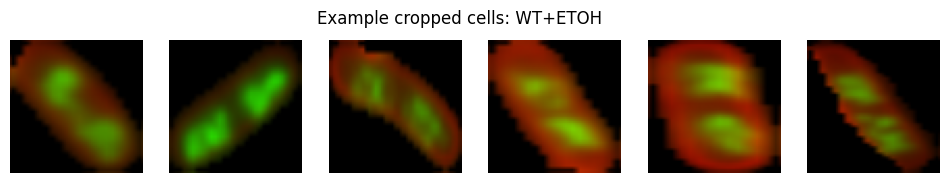

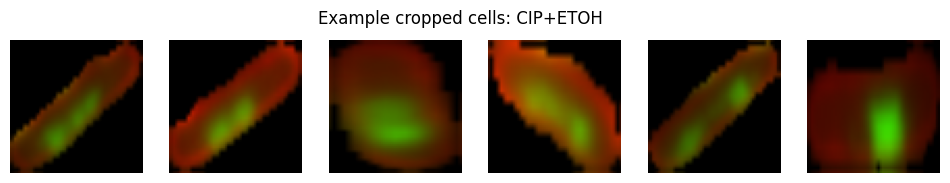

WT+ETOH: mean intensity ~ 29.38 (std 12.30)
CIP+ETOH: mean intensity ~ 27.39 (std 8.82)
Starting Optuna study. Base dir: ./models/classification/optuna_EfficientNetB0_WT_ETOH_CIP_ETOH_patientSplitOff_overlap_20260123-214632


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/optuna/_experimental.py:33: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  optuna_warn(
[I 2026-01-23 21:46:32,900] A new study created in RDB with name: optuna_EfficientNetB0_WT_ETOH_CIP_ETOH_patientSplitOff_overlap_20260123-214632
2026-01-23 21:46:33.169362: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your 

DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/imagecorruptions/corruptions.py:17: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename
/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 203s - loss: 0.6398 - accuracy: 0.6743 - val_loss: 0.6087 - val_accuracy: 0.7293 - 203s/epoch - 117ms/step
Epoch 2/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 171s - loss: 0.4878 - accuracy: 0.7882 - val_loss: 0.4197 - val_accuracy: 0.8479 - 171s/epoch - 99ms/step
Epoch 3/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 171s - loss: 0.4653 - accuracy: 0.7945 - val_loss: 0.3609 - val_accuracy: 0.8514 - 171s/epoch - 99ms/step
Epoch 4/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 171s - loss: 0.4271 - accuracy: 0.8136 - val_loss: 0.3243 - val_accuracy: 0.8710 - 171s/epoch - 99ms/step
Epoch 5/40
1730/1730 - 170s - loss: 0.4108 - accuracy: 0.8207 - val_loss: 0.3440 - val_accuracy: 0.8427 - 170s/epoch - 98ms/step
Epoch 6/40
1730/1730 - 167s - loss: 0.3955 - accuracy: 0.8285 - val_loss: 0.3572 - val_accuracy: 0.8496 - 167s/epoch - 96ms/step
Epoch 7/40
1730/1730 - 171s - loss: 0.3818 - accuracy: 0.8360 - val_loss: 0.3263 - val_accuracy: 0.8577 - 171s/epoch - 99ms/step
Epoch 8/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 172s - loss: 0.3742 - accuracy: 0.8442 - val_loss: 0.3021 - val_accuracy: 0.8762 - 172s/epoch - 99ms/step
Epoch 9/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 173s - loss: 0.3629 - accuracy: 0.8442 - val_loss: 0.3014 - val_accuracy: 0.8837 - 173s/epoch - 100ms/step
Epoch 10/40
1730/1730 - 170s - loss: 0.3633 - accuracy: 0.8458 - val_loss: 0.3100 - val_accuracy: 0.8780 - 170s/epoch - 99ms/step
Epoch 11/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 172s - loss: 0.3441 - accuracy: 0.8533 - val_loss: 0.2969 - val_accuracy: 0.8809 - 172s/epoch - 99ms/step
Epoch 12/40
1730/1730 - 171s - loss: 0.3448 - accuracy: 0.8513 - val_loss: 0.3040 - val_accuracy: 0.8832 - 171s/epoch - 99ms/step
Epoch 13/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 172s - loss: 0.3407 - accuracy: 0.8517 - val_loss: 0.2747 - val_accuracy: 0.8947 - 172s/epoch - 100ms/step
Epoch 14/40
1730/1730 - 171s - loss: 0.3307 - accuracy: 0.8614 - val_loss: 0.2965 - val_accuracy: 0.8762 - 171s/epoch - 99ms/step
Epoch 15/40
1730/1730 - 170s - loss: 0.3229 - accuracy: 0.8597 - val_loss: 0.3141 - val_accuracy: 0.8704 - 170s/epoch - 98ms/step
Epoch 16/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 171s - loss: 0.3180 - accuracy: 0.8578 - val_loss: 0.2684 - val_accuracy: 0.8924 - 171s/epoch - 99ms/step
Epoch 17/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 172s - loss: 0.3193 - accuracy: 0.8634 - val_loss: 0.2633 - val_accuracy: 0.9092 - 172s/epoch - 100ms/step
Epoch 18/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 172s - loss: 0.3206 - accuracy: 0.8613 - val_loss: 0.2600 - val_accuracy: 0.8994 - 172s/epoch - 99ms/step
Epoch 19/40
1730/1730 - 171s - loss: 0.3127 - accuracy: 0.8708 - val_loss: 0.2672 - val_accuracy: 0.8988 - 171s/epoch - 99ms/step
Epoch 20/40
1730/1730 - 170s - loss: 0.3122 - accuracy: 0.8639 - val_loss: 0.2683 - val_accuracy: 0.9208 - 170s/epoch - 99ms/step
Epoch 21/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 172s - loss: 0.3102 - accuracy: 0.8676 - val_loss: 0.2578 - val_accuracy: 0.9092 - 172s/epoch - 99ms/step
Epoch 22/40
1730/1730 - 172s - loss: 0.3084 - accuracy: 0.8685 - val_loss: 0.2688 - val_accuracy: 0.9069 - 172s/epoch - 99ms/step
Epoch 23/40
1730/1730 - 170s - loss: 0.3003 - accuracy: 0.8720 - val_loss: 0.3211 - val_accuracy: 0.8462 - 170s/epoch - 99ms/step
Epoch 24/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 169s - loss: 0.2968 - accuracy: 0.8743 - val_loss: 0.2319 - val_accuracy: 0.9190 - 169s/epoch - 98ms/step
Epoch 25/40
1730/1730 - 171s - loss: 0.2947 - accuracy: 0.8708 - val_loss: 0.2573 - val_accuracy: 0.9092 - 171s/epoch - 99ms/step
Epoch 26/40
1730/1730 - 171s - loss: 0.2988 - accuracy: 0.8669 - val_loss: 0.2326 - val_accuracy: 0.9075 - 171s/epoch - 99ms/step
Epoch 27/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 172s - loss: 0.2875 - accuracy: 0.8775 - val_loss: 0.2190 - val_accuracy: 0.9184 - 172s/epoch - 100ms/step
Epoch 28/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 171s - loss: 0.2839 - accuracy: 0.8795 - val_loss: 0.2163 - val_accuracy: 0.9213 - 171s/epoch - 99ms/step
Epoch 29/40
1730/1730 - 172s - loss: 0.2961 - accuracy: 0.8730 - val_loss: 0.2232 - val_accuracy: 0.9219 - 172s/epoch - 100ms/step
Epoch 30/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 172s - loss: 0.2876 - accuracy: 0.8776 - val_loss: 0.2131 - val_accuracy: 0.9294 - 172s/epoch - 100ms/step
Epoch 31/40
1730/1730 - 172s - loss: 0.2871 - accuracy: 0.8767 - val_loss: 0.2243 - val_accuracy: 0.9254 - 172s/epoch - 100ms/step
Epoch 32/40
1730/1730 - 172s - loss: 0.2866 - accuracy: 0.8767 - val_loss: 0.2324 - val_accuracy: 0.9063 - 172s/epoch - 99ms/step
Epoch 33/40
1730/1730 - 171s - loss: 0.2777 - accuracy: 0.8834 - val_loss: 0.2223 - val_accuracy: 0.9127 - 171s/epoch - 99ms/step
Epoch 34/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 172s - loss: 0.2778 - accuracy: 0.8845 - val_loss: 0.1983 - val_accuracy: 0.9294 - 172s/epoch - 100ms/step
Epoch 35/40
1730/1730 - 171s - loss: 0.2748 - accuracy: 0.8811 - val_loss: 0.2298 - val_accuracy: 0.9080 - 171s/epoch - 99ms/step
Epoch 36/40
1730/1730 - 171s - loss: 0.2684 - accuracy: 0.8889 - val_loss: 0.2125 - val_accuracy: 0.9231 - 171s/epoch - 99ms/step
Epoch 37/40
1730/1730 - 171s - loss: 0.2691 - accuracy: 0.8861 - val_loss: 0.2444 - val_accuracy: 0.8999 - 171s/epoch - 99ms/step
Epoch 38/40
1730/1730 - 171s - loss: 0.2717 - accuracy: 0.8827 - val_loss: 0.2196 - val_accuracy: 0.9127 - 171s/epoch - 99ms/step
Epoch 39/40
1730/1730 - 171s - loss: 0.2638 - accuracy: 0.8879 - val_loss: 0.2132 - val_accuracy: 0.9144 - 171s/epoch - 99ms/step
Epoch 40/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 172s - loss: 0.2679 - accuracy: 0.8871 - val_loss: 0.1972 - val_accuracy: 0.9283 - 172s/epoch - 99ms/step


[I 2026-01-23 23:41:14,803] Trial 0 finished with value: 0.9294390082359314 and parameters: {'dropout_rate': 0.22472407130841748, 'learning_rate': 0.0022648248189516837, 'patience': 10}. Best is trial 0 with value: 0.9294390082359314.


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 218s - loss: 0.6505 - accuracy: 0.6767 - val_loss: 0.5537 - val_accuracy: 0.7785 - 218s/epoch - 126ms/step
Epoch 2/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 173s - loss: 0.5006 - accuracy: 0.7777 - val_loss: 0.4462 - val_accuracy: 0.8479 - 173s/epoch - 100ms/step
Epoch 3/40
1730/1730 - 173s - loss: 0.4470 - accuracy: 0.8040 - val_loss: 0.4719 - val_accuracy: 0.7999 - 173s/epoch - 100ms/step
Epoch 4/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 174s - loss: 0.4220 - accuracy: 0.8147 - val_loss: 0.4257 - val_accuracy: 0.7820 - 174s/epoch - 100ms/step
Epoch 5/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 173s - loss: 0.4071 - accuracy: 0.8270 - val_loss: 0.3326 - val_accuracy: 0.8635 - 173s/epoch - 100ms/step
Epoch 6/40
1730/1730 - 172s - loss: 0.3922 - accuracy: 0.8345 - val_loss: 0.5020 - val_accuracy: 0.7334 - 172s/epoch - 100ms/step
Epoch 7/40
1730/1730 - 170s - loss: 0.3840 - accuracy: 0.8386 - val_loss: 0.3369 - val_accuracy: 0.8687 - 170s/epoch - 98ms/step
Epoch 8/40
1730/1730 - 168s - loss: 0.3753 - accuracy: 0.8374 - val_loss: 0.4028 - val_accuracy: 0.8190 - 168s/epoch - 97ms/step
Epoch 9/40
1730/1730 - 172s - loss: 0.3715 - accuracy: 0.8354 - val_loss: 0.3835 - val_accuracy: 0.8514 - 172s/epoch - 99ms/step


[I 2026-01-24 00:07:50,147] Trial 1 finished with value: 0.8687102198600769 and parameters: {'dropout_rate': 0.35919509051822196, 'learning_rate': 2.4348773534554605e-05, 'patience': 4}. Best is trial 0 with value: 0.9294390082359314.


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 211s - loss: 0.6140 - accuracy: 0.7026 - val_loss: 0.4039 - val_accuracy: 0.8311 - 211s/epoch - 122ms/step
Epoch 2/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 169s - loss: 0.4802 - accuracy: 0.7841 - val_loss: 0.3330 - val_accuracy: 0.8554 - 169s/epoch - 98ms/step
Epoch 3/40
1730/1730 - 168s - loss: 0.4446 - accuracy: 0.8027 - val_loss: 0.3756 - val_accuracy: 0.8595 - 168s/epoch - 97ms/step
Epoch 4/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 168s - loss: 0.4198 - accuracy: 0.8215 - val_loss: 0.3277 - val_accuracy: 0.8629 - 168s/epoch - 97ms/step
Epoch 5/40
1730/1730 - 167s - loss: 0.4033 - accuracy: 0.8266 - val_loss: 0.3589 - val_accuracy: 0.8415 - 167s/epoch - 97ms/step
Epoch 6/40
1730/1730 - 169s - loss: 0.3976 - accuracy: 0.8314 - val_loss: 0.3626 - val_accuracy: 0.8560 - 169s/epoch - 97ms/step
Epoch 7/40
1730/1730 - 168s - loss: 0.3917 - accuracy: 0.8299 - val_loss: 0.3416 - val_accuracy: 0.8485 - 168s/epoch - 97ms/step
Epoch 8/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 169s - loss: 0.3812 - accuracy: 0.8345 - val_loss: 0.3138 - val_accuracy: 0.8704 - 169s/epoch - 98ms/step
Epoch 9/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 168s - loss: 0.3633 - accuracy: 0.8422 - val_loss: 0.2786 - val_accuracy: 0.8901 - 168s/epoch - 97ms/step
Epoch 10/40
1730/1730 - 168s - loss: 0.3622 - accuracy: 0.8412 - val_loss: 0.3252 - val_accuracy: 0.8687 - 168s/epoch - 97ms/step
Epoch 11/40
1730/1730 - 168s - loss: 0.3578 - accuracy: 0.8425 - val_loss: 0.2912 - val_accuracy: 0.8814 - 168s/epoch - 97ms/step
Epoch 12/40
1730/1730 - 168s - loss: 0.3502 - accuracy: 0.8494 - val_loss: 0.4196 - val_accuracy: 0.8143 - 168s/epoch - 97ms/step
Epoch 13/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 169s - loss: 0.3415 - accuracy: 0.8499 - val_loss: 0.2679 - val_accuracy: 0.8971 - 169s/epoch - 98ms/step
Epoch 14/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 169s - loss: 0.3367 - accuracy: 0.8556 - val_loss: 0.2673 - val_accuracy: 0.8976 - 169s/epoch - 97ms/step
Epoch 15/40
1730/1730 - 168s - loss: 0.3379 - accuracy: 0.8540 - val_loss: 0.2755 - val_accuracy: 0.8959 - 168s/epoch - 97ms/step
Epoch 16/40
1730/1730 - 162s - loss: 0.3300 - accuracy: 0.8564 - val_loss: 0.2881 - val_accuracy: 0.8843 - 162s/epoch - 93ms/step
Epoch 17/40
1730/1730 - 168s - loss: 0.3276 - accuracy: 0.8591 - val_loss: 0.2760 - val_accuracy: 0.8942 - 168s/epoch - 97ms/step
Epoch 18/40
1730/1730 - 167s - loss: 0.3186 - accuracy: 0.8646 - val_loss: 0.2885 - val_accuracy: 0.8797 - 167s/epoch - 97ms/step
Epoch 19/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 169s - loss: 0.3193 - accuracy: 0.8629 - val_loss: 0.2591 - val_accuracy: 0.9104 - 169s/epoch - 97ms/step
Epoch 20/40
1730/1730 - 168s - loss: 0.3146 - accuracy: 0.8655 - val_loss: 0.2867 - val_accuracy: 0.8809 - 168s/epoch - 97ms/step
Epoch 21/40
1730/1730 - 168s - loss: 0.3131 - accuracy: 0.8665 - val_loss: 0.2602 - val_accuracy: 0.8971 - 168s/epoch - 97ms/step
Epoch 22/40
1730/1730 - 168s - loss: 0.3092 - accuracy: 0.8688 - val_loss: 0.2830 - val_accuracy: 0.8936 - 168s/epoch - 97ms/step
Epoch 23/40
1730/1730 - 167s - loss: 0.3041 - accuracy: 0.8672 - val_loss: 0.3076 - val_accuracy: 0.8704 - 167s/epoch - 97ms/step
Epoch 24/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 168s - loss: 0.3013 - accuracy: 0.8659 - val_loss: 0.2461 - val_accuracy: 0.9098 - 168s/epoch - 97ms/step
Epoch 25/40
1730/1730 - 168s - loss: 0.2991 - accuracy: 0.8718 - val_loss: 0.3268 - val_accuracy: 0.8560 - 168s/epoch - 97ms/step
Epoch 26/40
1730/1730 - 168s - loss: 0.3031 - accuracy: 0.8711 - val_loss: 0.3141 - val_accuracy: 0.8884 - 168s/epoch - 97ms/step
Epoch 27/40
1730/1730 - 167s - loss: 0.2945 - accuracy: 0.8743 - val_loss: 0.2658 - val_accuracy: 0.9028 - 167s/epoch - 97ms/step
Epoch 28/40
1730/1730 - 168s - loss: 0.2921 - accuracy: 0.8717 - val_loss: 0.2576 - val_accuracy: 0.8982 - 168s/epoch - 97ms/step
Epoch 29/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 169s - loss: 0.2942 - accuracy: 0.8728 - val_loss: 0.2339 - val_accuracy: 0.9063 - 169s/epoch - 97ms/step
Epoch 30/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 169s - loss: 0.2822 - accuracy: 0.8814 - val_loss: 0.2291 - val_accuracy: 0.9184 - 169s/epoch - 98ms/step
Epoch 31/40
1730/1730 - 167s - loss: 0.2870 - accuracy: 0.8814 - val_loss: 0.3091 - val_accuracy: 0.8687 - 167s/epoch - 97ms/step
Epoch 32/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 169s - loss: 0.2817 - accuracy: 0.8796 - val_loss: 0.2194 - val_accuracy: 0.9213 - 169s/epoch - 97ms/step
Epoch 33/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 168s - loss: 0.2864 - accuracy: 0.8790 - val_loss: 0.2112 - val_accuracy: 0.9179 - 168s/epoch - 97ms/step
Epoch 34/40
1730/1730 - 170s - loss: 0.2822 - accuracy: 0.8809 - val_loss: 0.2235 - val_accuracy: 0.9294 - 170s/epoch - 98ms/step
Epoch 35/40
1730/1730 - 169s - loss: 0.2797 - accuracy: 0.8776 - val_loss: 0.2419 - val_accuracy: 0.9017 - 169s/epoch - 97ms/step
Epoch 36/40
1730/1730 - 169s - loss: 0.2771 - accuracy: 0.8821 - val_loss: 0.2214 - val_accuracy: 0.9219 - 169s/epoch - 98ms/step
Epoch 37/40
1730/1730 - 166s - loss: 0.2656 - accuracy: 0.8829 - val_loss: 0.2193 - val_accuracy: 0.9219 - 166s/epoch - 96ms/step
Epoch 38/40
1730/1730 - 168s - loss: 0.2707 - accuracy: 0.8868 - val_loss: 0.2342 - val_accuracy: 0.9104 - 168s/epoch - 97ms/step
Epoch 39/40
1730/1730 - 169s - loss: 0.2724 - accuracy: 0.8863 - val_loss: 0.2222 - val_accuracy: 0.9138 - 169s/epoch - 98ms/step
Epoch 40/40
1730/1730 - 168s - loss: 0.2634 - accuracy: 0.8897 - val_loss: 0.2499 - val_accuracy: 0.90

[I 2026-01-24 02:00:37,429] Trial 2 finished with value: 0.9294390082359314 and parameters: {'dropout_rate': 0.03485016730091967, 'learning_rate': 0.0013983740016490966, 'patience': 9}. Best is trial 0 with value: 0.9294390082359314.


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 211s - loss: 0.6346 - accuracy: 0.6832 - val_loss: 0.4265 - val_accuracy: 0.8074 - 211s/epoch - 122ms/step
Epoch 2/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 171s - loss: 0.5117 - accuracy: 0.7672 - val_loss: 0.3873 - val_accuracy: 0.8508 - 171s/epoch - 99ms/step
Epoch 3/40
1730/1730 - 169s - loss: 0.4519 - accuracy: 0.7980 - val_loss: 0.3918 - val_accuracy: 0.8502 - 169s/epoch - 98ms/step
Epoch 4/40
1730/1730 - 169s - loss: 0.4276 - accuracy: 0.8114 - val_loss: 0.5089 - val_accuracy: 0.7565 - 169s/epoch - 98ms/step
Epoch 5/40
1730/1730 - 169s - loss: 0.4144 - accuracy: 0.8189 - val_loss: 0.4567 - val_accuracy: 0.8265 - 169s/epoch - 98ms/step
Epoch 6/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.4047 - accuracy: 0.8230 - val_loss: 0.3475 - val_accuracy: 0.8791 - 170s/epoch - 98ms/step
Epoch 7/40
1730/1730 - 169s - loss: 0.3899 - accuracy: 0.8340 - val_loss: 0.3575 - val_accuracy: 0.8392 - 169s/epoch - 97ms/step
Epoch 8/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 169s - loss: 0.3746 - accuracy: 0.8405 - val_loss: 0.2968 - val_accuracy: 0.8907 - 169s/epoch - 98ms/step
Epoch 9/40
1730/1730 - 168s - loss: 0.3715 - accuracy: 0.8383 - val_loss: 0.3366 - val_accuracy: 0.8733 - 168s/epoch - 97ms/step
Epoch 10/40
1730/1730 - 169s - loss: 0.3662 - accuracy: 0.8396 - val_loss: 0.3147 - val_accuracy: 0.8658 - 169s/epoch - 98ms/step
Epoch 11/40
1730/1730 - 169s - loss: 0.3613 - accuracy: 0.8413 - val_loss: 0.3316 - val_accuracy: 0.8658 - 169s/epoch - 98ms/step
Epoch 12/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.3551 - accuracy: 0.8468 - val_loss: 0.2856 - val_accuracy: 0.8832 - 170s/epoch - 98ms/step
Epoch 13/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 169s - loss: 0.3468 - accuracy: 0.8465 - val_loss: 0.2801 - val_accuracy: 0.8913 - 169s/epoch - 98ms/step
Epoch 14/40
1730/1730 - 169s - loss: 0.3361 - accuracy: 0.8591 - val_loss: 0.2813 - val_accuracy: 0.8884 - 169s/epoch - 97ms/step
Epoch 15/40
1730/1730 - 169s - loss: 0.3411 - accuracy: 0.8507 - val_loss: 0.2844 - val_accuracy: 0.8918 - 169s/epoch - 98ms/step
Epoch 16/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.3296 - accuracy: 0.8539 - val_loss: 0.2790 - val_accuracy: 0.8901 - 170s/epoch - 98ms/step
Epoch 17/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.3344 - accuracy: 0.8561 - val_loss: 0.2764 - val_accuracy: 0.8878 - 170s/epoch - 98ms/step
Epoch 18/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.3303 - accuracy: 0.8577 - val_loss: 0.2602 - val_accuracy: 0.9063 - 170s/epoch - 98ms/step
Epoch 19/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 169s - loss: 0.3216 - accuracy: 0.8605 - val_loss: 0.2599 - val_accuracy: 0.8994 - 169s/epoch - 98ms/step
Epoch 20/40
1730/1730 - 169s - loss: 0.3283 - accuracy: 0.8598 - val_loss: 0.2677 - val_accuracy: 0.8936 - 169s/epoch - 98ms/step
Epoch 21/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 169s - loss: 0.3191 - accuracy: 0.8610 - val_loss: 0.2267 - val_accuracy: 0.9138 - 169s/epoch - 98ms/step
Epoch 22/40
1730/1730 - 169s - loss: 0.3145 - accuracy: 0.8626 - val_loss: 0.2677 - val_accuracy: 0.8953 - 169s/epoch - 98ms/step
Epoch 23/40
1730/1730 - 168s - loss: 0.3048 - accuracy: 0.8705 - val_loss: 0.2464 - val_accuracy: 0.9109 - 168s/epoch - 97ms/step
Epoch 24/40
1730/1730 - 169s - loss: 0.3144 - accuracy: 0.8597 - val_loss: 0.3299 - val_accuracy: 0.8490 - 169s/epoch - 98ms/step
Epoch 25/40
1730/1730 - 168s - loss: 0.3082 - accuracy: 0.8676 - val_loss: 0.2449 - val_accuracy: 0.9127 - 168s/epoch - 97ms/step
Epoch 26/40
1730/1730 - 169s - loss: 0.3037 - accuracy: 0.8656 - val_loss: 0.2508 - val_accuracy: 0.9057 - 169s/epoch - 98ms/step
Epoch 27/40
1730/1730 - 169s - loss: 0.3078 - accuracy: 0.8691 - val_loss: 0.2672 - val_accuracy: 0.8942 - 169s/epoch - 98ms/step
Epoch 28/40
1730/1730 - 169s - loss: 0.3020 - accuracy: 0.8733 - val_loss: 0.2372 - val_accuracy: 0.91

/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.3023 - accuracy: 0.8711 - val_loss: 0.2256 - val_accuracy: 0.9109 - 170s/epoch - 98ms/step
Epoch 30/40
1730/1730 - 168s - loss: 0.2944 - accuracy: 0.8780 - val_loss: 0.2859 - val_accuracy: 0.8785 - 168s/epoch - 97ms/step
Epoch 31/40
1730/1730 - 169s - loss: 0.2934 - accuracy: 0.8749 - val_loss: 0.2364 - val_accuracy: 0.9028 - 169s/epoch - 98ms/step
Epoch 32/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.2893 - accuracy: 0.8779 - val_loss: 0.2176 - val_accuracy: 0.9138 - 170s/epoch - 98ms/step
Epoch 33/40
1730/1730 - 169s - loss: 0.2904 - accuracy: 0.8796 - val_loss: 0.2591 - val_accuracy: 0.8843 - 169s/epoch - 98ms/step
Epoch 34/40
1730/1730 - 169s - loss: 0.2903 - accuracy: 0.8741 - val_loss: 0.2701 - val_accuracy: 0.8924 - 169s/epoch - 97ms/step
Epoch 35/40
1730/1730 - 169s - loss: 0.2814 - accuracy: 0.8842 - val_loss: 0.2219 - val_accuracy: 0.9231 - 169s/epoch - 98ms/step
Epoch 36/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.2859 - accuracy: 0.8770 - val_loss: 0.2140 - val_accuracy: 0.9265 - 170s/epoch - 98ms/step
Epoch 37/40
1730/1730 - 170s - loss: 0.2808 - accuracy: 0.8805 - val_loss: 0.2198 - val_accuracy: 0.9300 - 170s/epoch - 98ms/step
Epoch 38/40
1730/1730 - 169s - loss: 0.2746 - accuracy: 0.8819 - val_loss: 0.2230 - val_accuracy: 0.9127 - 169s/epoch - 98ms/step
Epoch 39/40
1730/1730 - 169s - loss: 0.2815 - accuracy: 0.8773 - val_loss: 0.2347 - val_accuracy: 0.9051 - 169s/epoch - 98ms/step
Epoch 40/40
1730/1730 - 169s - loss: 0.2746 - accuracy: 0.8808 - val_loss: 0.2364 - val_accuracy: 0.9040 - 169s/epoch - 98ms/step


[I 2026-01-24 03:54:11,191] Trial 3 finished with value: 0.930017352104187 and parameters: {'dropout_rate': 0.4248435466776273, 'learning_rate': 1.1245798259119336e-05, 'patience': 12}. Best is trial 3 with value: 0.930017352104187.


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 212s - loss: 0.6532 - accuracy: 0.6801 - val_loss: 0.4143 - val_accuracy: 0.7981 - 212s/epoch - 122ms/step
Epoch 2/40
1730/1730 - 169s - loss: 0.5162 - accuracy: 0.7611 - val_loss: 0.4980 - val_accuracy: 0.7345 - 169s/epoch - 98ms/step
Epoch 3/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 167s - loss: 0.4525 - accuracy: 0.8010 - val_loss: 0.4083 - val_accuracy: 0.8456 - 167s/epoch - 96ms/step
Epoch 4/40
1730/1730 - 168s - loss: 0.4296 - accuracy: 0.8140 - val_loss: 0.4243 - val_accuracy: 0.8051 - 168s/epoch - 97ms/step
Epoch 5/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 169s - loss: 0.4097 - accuracy: 0.8197 - val_loss: 0.3442 - val_accuracy: 0.8612 - 169s/epoch - 97ms/step
Epoch 6/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 168s - loss: 0.3980 - accuracy: 0.8257 - val_loss: 0.3262 - val_accuracy: 0.8670 - 168s/epoch - 97ms/step
Epoch 7/40
1730/1730 - 167s - loss: 0.3895 - accuracy: 0.8276 - val_loss: 0.3274 - val_accuracy: 0.8537 - 167s/epoch - 96ms/step
Epoch 8/40
1730/1730 - 168s - loss: 0.3745 - accuracy: 0.8390 - val_loss: 0.3287 - val_accuracy: 0.8693 - 168s/epoch - 97ms/step
Epoch 9/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 168s - loss: 0.3763 - accuracy: 0.8342 - val_loss: 0.3177 - val_accuracy: 0.8676 - 168s/epoch - 97ms/step
Epoch 10/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 168s - loss: 0.3694 - accuracy: 0.8355 - val_loss: 0.3002 - val_accuracy: 0.8820 - 168s/epoch - 97ms/step
Epoch 11/40
1730/1730 - 167s - loss: 0.3593 - accuracy: 0.8422 - val_loss: 0.3220 - val_accuracy: 0.8577 - 167s/epoch - 97ms/step
Epoch 12/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 168s - loss: 0.3547 - accuracy: 0.8436 - val_loss: 0.2731 - val_accuracy: 0.8907 - 168s/epoch - 97ms/step
Epoch 13/40
1730/1730 - 167s - loss: 0.3469 - accuracy: 0.8507 - val_loss: 0.2858 - val_accuracy: 0.8907 - 167s/epoch - 97ms/step
Epoch 14/40
1730/1730 - 168s - loss: 0.3363 - accuracy: 0.8546 - val_loss: 0.3096 - val_accuracy: 0.8762 - 168s/epoch - 97ms/step
Epoch 15/40
1730/1730 - 167s - loss: 0.3378 - accuracy: 0.8591 - val_loss: 0.2814 - val_accuracy: 0.8907 - 167s/epoch - 97ms/step
Epoch 16/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 168s - loss: 0.3382 - accuracy: 0.8558 - val_loss: 0.2664 - val_accuracy: 0.8976 - 168s/epoch - 97ms/step
Epoch 17/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 168s - loss: 0.3279 - accuracy: 0.8603 - val_loss: 0.2552 - val_accuracy: 0.8965 - 168s/epoch - 97ms/step
Epoch 18/40
1730/1730 - 169s - loss: 0.3221 - accuracy: 0.8626 - val_loss: 0.2827 - val_accuracy: 0.8866 - 169s/epoch - 98ms/step
Epoch 19/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 169s - loss: 0.3162 - accuracy: 0.8637 - val_loss: 0.2476 - val_accuracy: 0.9011 - 169s/epoch - 98ms/step
Epoch 20/40
1730/1730 - 168s - loss: 0.3143 - accuracy: 0.8656 - val_loss: 0.2742 - val_accuracy: 0.9046 - 168s/epoch - 97ms/step
Epoch 21/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 169s - loss: 0.3101 - accuracy: 0.8681 - val_loss: 0.2390 - val_accuracy: 0.9184 - 169s/epoch - 98ms/step
Epoch 22/40
1730/1730 - 168s - loss: 0.3103 - accuracy: 0.8672 - val_loss: 0.2616 - val_accuracy: 0.8924 - 168s/epoch - 97ms/step
Epoch 23/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 169s - loss: 0.3051 - accuracy: 0.8695 - val_loss: 0.2370 - val_accuracy: 0.9121 - 169s/epoch - 98ms/step
Epoch 24/40
1730/1730 - 167s - loss: 0.3018 - accuracy: 0.8649 - val_loss: 0.2742 - val_accuracy: 0.8843 - 167s/epoch - 97ms/step
Epoch 25/40
1730/1730 - 168s - loss: 0.3050 - accuracy: 0.8723 - val_loss: 0.2575 - val_accuracy: 0.9086 - 168s/epoch - 97ms/step
Epoch 26/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 169s - loss: 0.2944 - accuracy: 0.8775 - val_loss: 0.2272 - val_accuracy: 0.9121 - 169s/epoch - 97ms/step
Epoch 27/40
1730/1730 - 169s - loss: 0.2918 - accuracy: 0.8728 - val_loss: 0.2754 - val_accuracy: 0.8872 - 169s/epoch - 98ms/step
Epoch 28/40
1730/1730 - 167s - loss: 0.2941 - accuracy: 0.8724 - val_loss: 0.2920 - val_accuracy: 0.8768 - 167s/epoch - 97ms/step
Epoch 29/40
1730/1730 - 168s - loss: 0.2910 - accuracy: 0.8796 - val_loss: 0.2328 - val_accuracy: 0.9150 - 168s/epoch - 97ms/step
Epoch 30/40
1730/1730 - 168s - loss: 0.2843 - accuracy: 0.8808 - val_loss: 0.2295 - val_accuracy: 0.9161 - 168s/epoch - 97ms/step


[I 2026-01-24 05:18:59,706] Trial 4 finished with value: 0.9184499979019165 and parameters: {'dropout_rate': 0.499465584480253, 'learning_rate': 3.357296705351791e-05, 'patience': 4}. Best is trial 3 with value: 0.930017352104187.


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 213s - loss: 0.6099 - accuracy: 0.7045 - val_loss: 0.4453 - val_accuracy: 0.8051 - 213s/epoch - 123ms/step
Epoch 2/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 171s - loss: 0.4759 - accuracy: 0.7866 - val_loss: 0.3842 - val_accuracy: 0.8462 - 171s/epoch - 99ms/step
Epoch 3/40
1730/1730 - 169s - loss: 0.4336 - accuracy: 0.8094 - val_loss: 0.4066 - val_accuracy: 0.8294 - 169s/epoch - 98ms/step
Epoch 4/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 171s - loss: 0.4193 - accuracy: 0.8111 - val_loss: 0.3396 - val_accuracy: 0.8473 - 171s/epoch - 99ms/step
Epoch 5/40
1730/1730 - 170s - loss: 0.4129 - accuracy: 0.8160 - val_loss: 0.3421 - val_accuracy: 0.8641 - 170s/epoch - 98ms/step
Epoch 6/40
1730/1730 - 170s - loss: 0.3824 - accuracy: 0.8358 - val_loss: 0.3625 - val_accuracy: 0.8739 - 170s/epoch - 98ms/step
Epoch 7/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 171s - loss: 0.3800 - accuracy: 0.8374 - val_loss: 0.2742 - val_accuracy: 0.8930 - 171s/epoch - 99ms/step
Epoch 8/40
1730/1730 - 170s - loss: 0.3726 - accuracy: 0.8377 - val_loss: 0.3014 - val_accuracy: 0.8797 - 170s/epoch - 98ms/step
Epoch 9/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 171s - loss: 0.3517 - accuracy: 0.8490 - val_loss: 0.2690 - val_accuracy: 0.8907 - 171s/epoch - 99ms/step
Epoch 10/40
1730/1730 - 170s - loss: 0.3534 - accuracy: 0.8480 - val_loss: 0.2901 - val_accuracy: 0.8774 - 170s/epoch - 98ms/step
Epoch 11/40
1730/1730 - 169s - loss: 0.3572 - accuracy: 0.8438 - val_loss: 0.2892 - val_accuracy: 0.9011 - 169s/epoch - 98ms/step
Epoch 12/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.3392 - accuracy: 0.8494 - val_loss: 0.2646 - val_accuracy: 0.8953 - 170s/epoch - 98ms/step
Epoch 13/40
1730/1730 - 170s - loss: 0.3427 - accuracy: 0.8503 - val_loss: 0.2683 - val_accuracy: 0.8982 - 170s/epoch - 98ms/step
Epoch 14/40
1730/1730 - 170s - loss: 0.3302 - accuracy: 0.8514 - val_loss: 0.2648 - val_accuracy: 0.8936 - 170s/epoch - 98ms/step
Epoch 15/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.3299 - accuracy: 0.8600 - val_loss: 0.2556 - val_accuracy: 0.9069 - 170s/epoch - 98ms/step
Epoch 16/40
1730/1730 - 166s - loss: 0.3206 - accuracy: 0.8665 - val_loss: 0.2570 - val_accuracy: 0.9005 - 166s/epoch - 96ms/step
Epoch 17/40
1730/1730 - 169s - loss: 0.3209 - accuracy: 0.8637 - val_loss: 0.3038 - val_accuracy: 0.8872 - 169s/epoch - 98ms/step
Epoch 18/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.3222 - accuracy: 0.8584 - val_loss: 0.2538 - val_accuracy: 0.9098 - 170s/epoch - 98ms/step
Epoch 19/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.3198 - accuracy: 0.8645 - val_loss: 0.2523 - val_accuracy: 0.9017 - 170s/epoch - 98ms/step
Epoch 20/40
1730/1730 - 169s - loss: 0.3126 - accuracy: 0.8643 - val_loss: 0.3838 - val_accuracy: 0.8317 - 169s/epoch - 98ms/step
Epoch 21/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.3077 - accuracy: 0.8673 - val_loss: 0.2484 - val_accuracy: 0.9127 - 170s/epoch - 98ms/step
Epoch 22/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 171s - loss: 0.3029 - accuracy: 0.8639 - val_loss: 0.2400 - val_accuracy: 0.9184 - 171s/epoch - 99ms/step
Epoch 23/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.3020 - accuracy: 0.8705 - val_loss: 0.2305 - val_accuracy: 0.9121 - 170s/epoch - 98ms/step
Epoch 24/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.2967 - accuracy: 0.8728 - val_loss: 0.2225 - val_accuracy: 0.9144 - 170s/epoch - 98ms/step
Epoch 25/40
1730/1730 - 169s - loss: 0.2980 - accuracy: 0.8740 - val_loss: 0.2448 - val_accuracy: 0.9034 - 169s/epoch - 98ms/step
Epoch 26/40
1730/1730 - 169s - loss: 0.2930 - accuracy: 0.8717 - val_loss: 0.2400 - val_accuracy: 0.9121 - 169s/epoch - 98ms/step
Epoch 27/40
1730/1730 - 169s - loss: 0.2941 - accuracy: 0.8740 - val_loss: 0.2286 - val_accuracy: 0.9156 - 169s/epoch - 98ms/step
Epoch 28/40
1730/1730 - 168s - loss: 0.2922 - accuracy: 0.8762 - val_loss: 0.2299 - val_accuracy: 0.9046 - 168s/epoch - 97ms/step
Epoch 29/40
1730/1730 - 168s - loss: 0.2840 - accuracy: 0.8777 - val_loss: 0.2509 - val_accuracy: 0.9167 - 168s/epoch - 97ms/step
Epoch 30/40
1730/1730 - 169s - loss: 0.2835 - accuracy: 0.8795 - val_loss: 0.2602 - val_accuracy: 0.9173 - 169s/epoch - 98ms/step
Epoch 31/40
1730/1730 - 170s - loss: 0.2922 - accuracy: 0.8737 - val_loss: 0.2554 - val_accuracy: 0.88

[I 2026-01-24 06:50:10,920] Trial 5 finished with value: 0.9184499979019165 and parameters: {'dropout_rate': 0.11004270591206029, 'learning_rate': 5.670807781371427e-05, 'patience': 8}. Best is trial 3 with value: 0.930017352104187.


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 214s - loss: 0.6228 - accuracy: 0.6915 - val_loss: 0.4205 - val_accuracy: 0.8265 - 214s/epoch - 123ms/step
Epoch 2/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 171s - loss: 0.4788 - accuracy: 0.7795 - val_loss: 0.3961 - val_accuracy: 0.8219 - 171s/epoch - 99ms/step
Epoch 3/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 172s - loss: 0.4429 - accuracy: 0.8052 - val_loss: 0.3549 - val_accuracy: 0.8456 - 172s/epoch - 99ms/step
Epoch 4/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 173s - loss: 0.4207 - accuracy: 0.8149 - val_loss: 0.3445 - val_accuracy: 0.8583 - 173s/epoch - 100ms/step
Epoch 5/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 172s - loss: 0.4097 - accuracy: 0.8221 - val_loss: 0.3289 - val_accuracy: 0.8728 - 172s/epoch - 99ms/step
Epoch 6/40
1730/1730 - 170s - loss: 0.3987 - accuracy: 0.8262 - val_loss: 0.3320 - val_accuracy: 0.8404 - 170s/epoch - 98ms/step
Epoch 7/40
1730/1730 - 170s - loss: 0.3851 - accuracy: 0.8308 - val_loss: 0.3425 - val_accuracy: 0.8716 - 170s/epoch - 98ms/step
Epoch 8/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
[I 2026-01-24 07:13:47,699] Trial 6 pruned. Pruned at epoch 7, val_accuracy=0.8640832901000977


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 215s - loss: 0.6170 - accuracy: 0.6918 - val_loss: 0.3777 - val_accuracy: 0.8462 - 215s/epoch - 124ms/step
Epoch 2/40
1730/1730 - 171s - loss: 0.5032 - accuracy: 0.7727 - val_loss: 0.3840 - val_accuracy: 0.8398 - 171s/epoch - 99ms/step
Epoch 3/40
1730/1730 - 171s - loss: 0.4550 - accuracy: 0.7981 - val_loss: 0.3921 - val_accuracy: 0.8276 - 171s/epoch - 99ms/step
Epoch 4/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 171s - loss: 0.4180 - accuracy: 0.8201 - val_loss: 0.3673 - val_accuracy: 0.8525 - 171s/epoch - 99ms/step
Epoch 5/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.4107 - accuracy: 0.8262 - val_loss: 0.3639 - val_accuracy: 0.8340 - 170s/epoch - 98ms/step
Epoch 6/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 171s - loss: 0.3836 - accuracy: 0.8309 - val_loss: 0.3035 - val_accuracy: 0.8866 - 171s/epoch - 99ms/step
Epoch 7/40
1730/1730 - 169s - loss: 0.3880 - accuracy: 0.8347 - val_loss: 0.3070 - val_accuracy: 0.8745 - 169s/epoch - 98ms/step
Epoch 8/40
1730/1730 - 169s - loss: 0.3763 - accuracy: 0.8389 - val_loss: 0.3355 - val_accuracy: 0.8543 - 169s/epoch - 98ms/step
Epoch 9/40
1730/1730 - 170s - loss: 0.3651 - accuracy: 0.8403 - val_loss: 0.3388 - val_accuracy: 0.8704 - 170s/epoch - 98ms/step
Epoch 10/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.3694 - accuracy: 0.8428 - val_loss: 0.2978 - val_accuracy: 0.8803 - 170s/epoch - 98ms/step
Epoch 11/40
1730/1730 - 169s - loss: 0.3453 - accuracy: 0.8514 - val_loss: 0.3215 - val_accuracy: 0.8676 - 169s/epoch - 97ms/step
Epoch 12/40
1730/1730 - 169s - loss: 0.3414 - accuracy: 0.8487 - val_loss: 0.2998 - val_accuracy: 0.8814 - 169s/epoch - 98ms/step
Epoch 13/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
[I 2026-01-24 07:51:24,739] Trial 7 pruned. Pruned at epoch 12, val_accuracy=0.8877964019775391


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 216s - loss: 0.6434 - accuracy: 0.6802 - val_loss: 0.4733 - val_accuracy: 0.8236 - 216s/epoch - 125ms/step
Epoch 2/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 174s - loss: 0.4992 - accuracy: 0.7721 - val_loss: 0.3737 - val_accuracy: 0.8427 - 174s/epoch - 100ms/step
Epoch 3/40
1730/1730 - 173s - loss: 0.4582 - accuracy: 0.8007 - val_loss: 0.4287 - val_accuracy: 0.8097 - 173s/epoch - 100ms/step
Epoch 4/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.4431 - accuracy: 0.8078 - val_loss: 0.3186 - val_accuracy: 0.8670 - 170s/epoch - 98ms/step
Epoch 5/40
1730/1730 - 173s - loss: 0.4134 - accuracy: 0.8212 - val_loss: 0.3287 - val_accuracy: 0.8658 - 173s/epoch - 100ms/step
Epoch 6/40
1730/1730 - 173s - loss: 0.3990 - accuracy: 0.8282 - val_loss: 0.3265 - val_accuracy: 0.8745 - 173s/epoch - 100ms/step
Epoch 7/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 174s - loss: 0.3835 - accuracy: 0.8361 - val_loss: 0.3106 - val_accuracy: 0.8745 - 174s/epoch - 100ms/step
Epoch 8/40
1730/1730 - 174s - loss: 0.3717 - accuracy: 0.8400 - val_loss: 0.3513 - val_accuracy: 0.8502 - 174s/epoch - 100ms/step
Epoch 9/40


[I 2026-01-24 08:18:07,689] Trial 8 pruned. Pruned at epoch 8, val_accuracy=0.8473106026649475


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 214s - loss: 0.6348 - accuracy: 0.6938 - val_loss: 0.5972 - val_accuracy: 0.7299 - 214s/epoch - 124ms/step
Epoch 2/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 169s - loss: 0.4884 - accuracy: 0.7773 - val_loss: 0.3837 - val_accuracy: 0.8329 - 169s/epoch - 98ms/step
Epoch 3/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 169s - loss: 0.4537 - accuracy: 0.8014 - val_loss: 0.3594 - val_accuracy: 0.8438 - 169s/epoch - 98ms/step
Epoch 4/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 169s - loss: 0.4298 - accuracy: 0.8100 - val_loss: 0.3512 - val_accuracy: 0.8647 - 169s/epoch - 98ms/step
Epoch 5/40
1730/1730 - 169s - loss: 0.4123 - accuracy: 0.8185 - val_loss: 0.3591 - val_accuracy: 0.8560 - 169s/epoch - 98ms/step
Epoch 6/40
1730/1730 - 169s - loss: 0.3956 - accuracy: 0.8332 - val_loss: 0.3582 - val_accuracy: 0.8485 - 169s/epoch - 97ms/step
Epoch 7/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.3891 - accuracy: 0.8392 - val_loss: 0.3414 - val_accuracy: 0.8571 - 170s/epoch - 98ms/step
Epoch 8/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
[I 2026-01-24 08:41:29,432] Trial 9 pruned. Pruned at epoch 7, val_accuracy=0.8571428656578064


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 215s - loss: 0.6683 - accuracy: 0.6540 - val_loss: 0.4183 - val_accuracy: 0.8068 - 215s/epoch - 124ms/step
Epoch 2/40
1730/1730 - 172s - loss: 0.5194 - accuracy: 0.7585 - val_loss: 0.4490 - val_accuracy: 0.8178 - 172s/epoch - 99ms/step
Epoch 3/40
1730/1730 - 172s - loss: 0.4594 - accuracy: 0.8025 - val_loss: 0.4312 - val_accuracy: 0.8404 - 172s/epoch - 99ms/step
Epoch 4/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 173s - loss: 0.4392 - accuracy: 0.8069 - val_loss: 0.3686 - val_accuracy: 0.8467 - 173s/epoch - 100ms/step
Epoch 5/40
1730/1730 - 172s - loss: 0.4092 - accuracy: 0.8243 - val_loss: 0.3828 - val_accuracy: 0.8496 - 172s/epoch - 100ms/step
Epoch 6/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
[I 2026-01-24 08:59:29,588] Trial 10 pruned. Pruned at epoch 5, val_accuracy=0.8554077744483948


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 217s - loss: 0.6481 - accuracy: 0.6801 - val_loss: 0.4629 - val_accuracy: 0.7964 - 217s/epoch - 126ms/step
Epoch 2/40
1730/1730 - 174s - loss: 0.4980 - accuracy: 0.7727 - val_loss: 0.4838 - val_accuracy: 0.7883 - 174s/epoch - 100ms/step
Epoch 3/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 174s - loss: 0.4429 - accuracy: 0.8058 - val_loss: 0.3300 - val_accuracy: 0.8548 - 174s/epoch - 100ms/step
Epoch 4/40
1730/1730 - 172s - loss: 0.4174 - accuracy: 0.8220 - val_loss: 0.3568 - val_accuracy: 0.8502 - 172s/epoch - 100ms/step
Epoch 5/40
1730/1730 - 173s - loss: 0.4059 - accuracy: 0.8263 - val_loss: 0.3368 - val_accuracy: 0.8612 - 173s/epoch - 100ms/step
Epoch 6/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 173s - loss: 0.3933 - accuracy: 0.8298 - val_loss: 0.3256 - val_accuracy: 0.8652 - 173s/epoch - 100ms/step
Epoch 7/40
1730/1730 - 173s - loss: 0.3908 - accuracy: 0.8292 - val_loss: 0.4458 - val_accuracy: 0.7311 - 173s/epoch - 100ms/step
Epoch 8/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.3786 - accuracy: 0.8331 - val_loss: 0.2877 - val_accuracy: 0.8814 - 170s/epoch - 98ms/step
Epoch 9/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 167s - loss: 0.3640 - accuracy: 0.8390 - val_loss: 0.2809 - val_accuracy: 0.8797 - 167s/epoch - 97ms/step
Epoch 10/40
1730/1730 - 172s - loss: 0.3599 - accuracy: 0.8408 - val_loss: 0.2836 - val_accuracy: 0.8785 - 172s/epoch - 100ms/step
Epoch 11/40
1730/1730 - 173s - loss: 0.3560 - accuracy: 0.8503 - val_loss: 0.3042 - val_accuracy: 0.8687 - 173s/epoch - 100ms/step
Epoch 12/40


[I 2026-01-24 09:34:42,819] Trial 11 pruned. Pruned at epoch 11, val_accuracy=0.8698669672012329


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 218s - loss: 0.6313 - accuracy: 0.6834 - val_loss: 0.4542 - val_accuracy: 0.7872 - 218s/epoch - 126ms/step
Epoch 2/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.4887 - accuracy: 0.7802 - val_loss: 0.4258 - val_accuracy: 0.8543 - 170s/epoch - 98ms/step
Epoch 3/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.4414 - accuracy: 0.8040 - val_loss: 0.3667 - val_accuracy: 0.8600 - 170s/epoch - 98ms/step
Epoch 4/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.4151 - accuracy: 0.8221 - val_loss: 0.3215 - val_accuracy: 0.8710 - 170s/epoch - 98ms/step
Epoch 5/40
1730/1730 - 170s - loss: 0.4135 - accuracy: 0.8189 - val_loss: 0.3648 - val_accuracy: 0.8687 - 170s/epoch - 98ms/step
Epoch 6/40
1730/1730 - 169s - loss: 0.3963 - accuracy: 0.8231 - val_loss: 0.3303 - val_accuracy: 0.8693 - 169s/epoch - 98ms/step
Epoch 7/40
1730/1730 - 169s - loss: 0.3848 - accuracy: 0.8324 - val_loss: 0.3470 - val_accuracy: 0.8595 - 169s/epoch - 98ms/step
Epoch 8/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
[I 2026-01-24 09:58:12,650] Trial 12 pruned. Pruned at epoch 7, val_accuracy=0.8606130480766296


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 212s - loss: 0.6505 - accuracy: 0.6767 - val_loss: 0.3887 - val_accuracy: 0.8438 - 212s/epoch - 123ms/step
Epoch 2/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 166s - loss: 0.4932 - accuracy: 0.7740 - val_loss: 0.3601 - val_accuracy: 0.8502 - 166s/epoch - 96ms/step
Epoch 3/40
1730/1730 - 169s - loss: 0.4485 - accuracy: 0.8014 - val_loss: 0.4573 - val_accuracy: 0.8282 - 169s/epoch - 98ms/step
Epoch 4/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 169s - loss: 0.4342 - accuracy: 0.8111 - val_loss: 0.3551 - val_accuracy: 0.8485 - 169s/epoch - 98ms/step
Epoch 5/40
1730/1730 - 168s - loss: 0.4039 - accuracy: 0.8241 - val_loss: 0.3720 - val_accuracy: 0.8728 - 168s/epoch - 97ms/step
Epoch 6/40
1730/1730 - 169s - loss: 0.3973 - accuracy: 0.8236 - val_loss: 0.4169 - val_accuracy: 0.8022 - 169s/epoch - 98ms/step
Epoch 7/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 169s - loss: 0.3840 - accuracy: 0.8338 - val_loss: 0.3218 - val_accuracy: 0.8837 - 169s/epoch - 98ms/step
Epoch 8/40
1730/1730 - 168s - loss: 0.3750 - accuracy: 0.8377 - val_loss: 0.3763 - val_accuracy: 0.8485 - 168s/epoch - 97ms/step
Epoch 9/40
1730/1730 - 158s - loss: 0.3661 - accuracy: 0.8449 - val_loss: 0.4089 - val_accuracy: 0.7976 - 158s/epoch - 91ms/step
Epoch 10/40
1730/1730 - 155s - loss: 0.3642 - accuracy: 0.8418 - val_loss: 0.3502 - val_accuracy: 0.8421 - 155s/epoch - 90ms/step
Epoch 11/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 156s - loss: 0.3533 - accuracy: 0.8461 - val_loss: 0.2911 - val_accuracy: 0.8699 - 156s/epoch - 90ms/step
Epoch 12/40
1730/1730 - 140s - loss: 0.3449 - accuracy: 0.8431 - val_loss: 0.3242 - val_accuracy: 0.8479 - 140s/epoch - 81ms/step
Epoch 13/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
[I 2026-01-24 10:34:02,556] Trial 13 pruned. Pruned at epoch 12, val_accuracy=0.8941584825515747


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 202s - loss: 0.6687 - accuracy: 0.6655 - val_loss: 0.4491 - val_accuracy: 0.8288 - 202s/epoch - 116ms/step
Epoch 2/40
1730/1730 - 156s - loss: 0.5009 - accuracy: 0.7753 - val_loss: 0.4639 - val_accuracy: 0.7756 - 156s/epoch - 90ms/step
Epoch 3/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 157s - loss: 0.4473 - accuracy: 0.8007 - val_loss: 0.3441 - val_accuracy: 0.8635 - 157s/epoch - 91ms/step
Epoch 4/40
1730/1730 - 158s - loss: 0.4276 - accuracy: 0.8114 - val_loss: 0.4667 - val_accuracy: 0.7854 - 158s/epoch - 91ms/step
Epoch 5/40
1730/1730 - 152s - loss: 0.4189 - accuracy: 0.8212 - val_loss: 0.4595 - val_accuracy: 0.7785 - 152s/epoch - 88ms/step
Epoch 6/40
1730/1730 - 155s - loss: 0.4018 - accuracy: 0.8295 - val_loss: 0.3838 - val_accuracy: 0.8502 - 155s/epoch - 90ms/step
Epoch 7/40
1730/1730 - 161s - loss: 0.3865 - accuracy: 0.8311 - val_loss: 0.3627 - val_accuracy: 0.8369 - 161s/epoch - 93ms/step
Epoch 8/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
[I 2026-01-24 10:55:49,277] Trial 14 pruned. Pruned at epoch 7, val_accuracy=0.8652400374412537


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 211s - loss: 0.6737 - accuracy: 0.6676 - val_loss: 0.5445 - val_accuracy: 0.7582 - 211s/epoch - 122ms/step
Epoch 2/40
1730/1730 - 163s - loss: 0.5028 - accuracy: 0.7734 - val_loss: 0.6610 - val_accuracy: 0.6790 - 163s/epoch - 94ms/step
Epoch 3/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 162s - loss: 0.4605 - accuracy: 0.7974 - val_loss: 0.3662 - val_accuracy: 0.8415 - 162s/epoch - 94ms/step
Epoch 4/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 159s - loss: 0.4296 - accuracy: 0.8129 - val_loss: 0.3496 - val_accuracy: 0.8543 - 159s/epoch - 92ms/step
Epoch 5/40
1730/1730 - 170s - loss: 0.4127 - accuracy: 0.8160 - val_loss: 0.3909 - val_accuracy: 0.8178 - 170s/epoch - 98ms/step
Epoch 6/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
[I 2026-01-24 11:13:07,852] Trial 15 pruned. Pruned at epoch 5, val_accuracy=0.856564462184906


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 208s - loss: 0.6467 - accuracy: 0.6795 - val_loss: 0.3929 - val_accuracy: 0.8392 - 208s/epoch - 121ms/step
Epoch 2/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 166s - loss: 0.4949 - accuracy: 0.7782 - val_loss: 0.3785 - val_accuracy: 0.8271 - 166s/epoch - 96ms/step
Epoch 3/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 167s - loss: 0.4550 - accuracy: 0.8014 - val_loss: 0.3508 - val_accuracy: 0.8543 - 167s/epoch - 97ms/step
Epoch 4/40
1730/1730 - 166s - loss: 0.4239 - accuracy: 0.8145 - val_loss: 0.3647 - val_accuracy: 0.8514 - 166s/epoch - 96ms/step
Epoch 5/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 167s - loss: 0.3949 - accuracy: 0.8289 - val_loss: 0.3347 - val_accuracy: 0.8739 - 167s/epoch - 97ms/step
Epoch 6/40
1730/1730 - 165s - loss: 0.4059 - accuracy: 0.8179 - val_loss: 0.3824 - val_accuracy: 0.8595 - 165s/epoch - 96ms/step
Epoch 7/40
1730/1730 - 165s - loss: 0.3844 - accuracy: 0.8360 - val_loss: 0.4060 - val_accuracy: 0.8271 - 165s/epoch - 96ms/step
Epoch 8/40
1730/1730 - 167s - loss: 0.3770 - accuracy: 0.8358 - val_loss: 0.3993 - val_accuracy: 0.8317 - 167s/epoch - 96ms/step
Epoch 9/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
[I 2026-01-24 11:38:52,060] Trial 16 pruned. Pruned at epoch 8, val_accuracy=0.8768073916435242


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 210s - loss: 0.6331 - accuracy: 0.6815 - val_loss: 0.4230 - val_accuracy: 0.8259 - 210s/epoch - 122ms/step
Epoch 2/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 168s - loss: 0.4868 - accuracy: 0.7889 - val_loss: 0.3900 - val_accuracy: 0.8236 - 168s/epoch - 97ms/step
Epoch 3/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 168s - loss: 0.4334 - accuracy: 0.8147 - val_loss: 0.3307 - val_accuracy: 0.8595 - 168s/epoch - 97ms/step
Epoch 4/40
1730/1730 - 166s - loss: 0.4206 - accuracy: 0.8173 - val_loss: 0.3463 - val_accuracy: 0.8479 - 166s/epoch - 96ms/step
Epoch 5/40
1730/1730 - 168s - loss: 0.4043 - accuracy: 0.8286 - val_loss: 0.5270 - val_accuracy: 0.7160 - 168s/epoch - 97ms/step
Epoch 6/40


[I 2026-01-24 11:56:24,908] Trial 17 pruned. Pruned at epoch 5, val_accuracy=0.8426836133003235


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 210s - loss: 0.6308 - accuracy: 0.6858 - val_loss: 0.4649 - val_accuracy: 0.8062 - 210s/epoch - 122ms/step
Epoch 2/40
1730/1730 - 167s - loss: 0.4822 - accuracy: 0.7803 - val_loss: 0.4713 - val_accuracy: 0.7617 - 167s/epoch - 97ms/step
Epoch 3/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 164s - loss: 0.4404 - accuracy: 0.8088 - val_loss: 0.3774 - val_accuracy: 0.8479 - 164s/epoch - 95ms/step
Epoch 4/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 168s - loss: 0.4221 - accuracy: 0.8230 - val_loss: 0.3661 - val_accuracy: 0.8537 - 168s/epoch - 97ms/step
Epoch 5/40
1730/1730 - 167s - loss: 0.4105 - accuracy: 0.8256 - val_loss: 0.4010 - val_accuracy: 0.8265 - 167s/epoch - 96ms/step
Epoch 6/40


[I 2026-01-24 12:13:51,319] Trial 18 pruned. Pruned at epoch 5, val_accuracy=0.8178137540817261


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 221s - loss: 0.6225 - accuracy: 0.6957 - val_loss: 0.4391 - val_accuracy: 0.8109 - 221s/epoch - 128ms/step
Epoch 2/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 172s - loss: 0.4843 - accuracy: 0.7793 - val_loss: 0.3965 - val_accuracy: 0.8415 - 172s/epoch - 100ms/step
Epoch 3/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.4477 - accuracy: 0.7993 - val_loss: 0.3746 - val_accuracy: 0.8444 - 170s/epoch - 99ms/step
Epoch 4/40
1730/1730 - 170s - loss: 0.4300 - accuracy: 0.8113 - val_loss: 0.3826 - val_accuracy: 0.8456 - 170s/epoch - 99ms/step
Epoch 5/40
1730/1730 - 172s - loss: 0.4052 - accuracy: 0.8215 - val_loss: 0.3915 - val_accuracy: 0.8531 - 172s/epoch - 99ms/step
Epoch 6/40


[I 2026-01-24 12:31:51,140] Trial 19 pruned. Pruned at epoch 5, val_accuracy=0.8502024412155151


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 213s - loss: 0.6713 - accuracy: 0.6553 - val_loss: 0.4222 - val_accuracy: 0.8352 - 213s/epoch - 123ms/step
Epoch 2/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 171s - loss: 0.4971 - accuracy: 0.7763 - val_loss: 0.4154 - val_accuracy: 0.8317 - 171s/epoch - 99ms/step
Epoch 3/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 171s - loss: 0.4448 - accuracy: 0.8051 - val_loss: 0.3692 - val_accuracy: 0.8600 - 171s/epoch - 99ms/step
Epoch 4/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 171s - loss: 0.4237 - accuracy: 0.8204 - val_loss: 0.3640 - val_accuracy: 0.8519 - 171s/epoch - 99ms/step
Epoch 5/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 171s - loss: 0.4139 - accuracy: 0.8215 - val_loss: 0.3187 - val_accuracy: 0.8791 - 171s/epoch - 99ms/step
Epoch 6/40
1730/1730 - 171s - loss: 0.3949 - accuracy: 0.8257 - val_loss: 0.3559 - val_accuracy: 0.8207 - 171s/epoch - 99ms/step
Epoch 7/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 170s - loss: 0.3868 - accuracy: 0.8400 - val_loss: 0.2783 - val_accuracy: 0.8953 - 170s/epoch - 98ms/step
Epoch 8/40
1730/1730 - 169s - loss: 0.3770 - accuracy: 0.8354 - val_loss: 0.4524 - val_accuracy: 0.7999 - 169s/epoch - 98ms/step
Epoch 9/40
1730/1730 - 170s - loss: 0.3727 - accuracy: 0.8334 - val_loss: 0.3195 - val_accuracy: 0.8647 - 170s/epoch - 98ms/step
Epoch 10/40
1730/1730 - 171s - loss: 0.3664 - accuracy: 0.8423 - val_loss: 0.3297 - val_accuracy: 0.8745 - 171s/epoch - 99ms/step
Epoch 11/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 171s - loss: 0.3475 - accuracy: 0.8551 - val_loss: 0.2619 - val_accuracy: 0.8982 - 171s/epoch - 99ms/step
Epoch 12/40
1730/1730 - 170s - loss: 0.3472 - accuracy: 0.8519 - val_loss: 0.2673 - val_accuracy: 0.8895 - 170s/epoch - 98ms/step
Epoch 13/40
1730/1730 - 170s - loss: 0.3468 - accuracy: 0.8480 - val_loss: 0.2933 - val_accuracy: 0.8791 - 170s/epoch - 98ms/step
Epoch 14/40
1730/1730 - 171s - loss: 0.3430 - accuracy: 0.8546 - val_loss: 0.2779 - val_accuracy: 0.8924 - 171s/epoch - 99ms/step
Epoch 15/40
1730/1730 - 170s - loss: 0.3340 - accuracy: 0.8546 - val_loss: 0.2737 - val_accuracy: 0.8918 - 170s/epoch - 98ms/step
Epoch 16/40
1730/1730 - 170s - loss: 0.3303 - accuracy: 0.8575 - val_loss: 0.3477 - val_accuracy: 0.8398 - 170s/epoch - 98ms/step
Epoch 17/40
1730/1730 - 170s - loss: 0.3220 - accuracy: 0.8645 - val_loss: 0.3045 - val_accuracy: 0.8757 - 170s/epoch - 98ms/step
Epoch 18/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
[I 2026-01-24 13:23:45,611] Trial 20 pruned. Pruned at epoch 17, val_accuracy=0.8982070684432983


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 210s - loss: 0.6185 - accuracy: 0.6977 - val_loss: 0.4142 - val_accuracy: 0.8242 - 210s/epoch - 121ms/step
Epoch 2/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 159s - loss: 0.4690 - accuracy: 0.7915 - val_loss: 0.3960 - val_accuracy: 0.8398 - 159s/epoch - 92ms/step
Epoch 3/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 160s - loss: 0.4465 - accuracy: 0.8025 - val_loss: 0.3892 - val_accuracy: 0.8329 - 160s/epoch - 92ms/step
Epoch 4/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 159s - loss: 0.4146 - accuracy: 0.8152 - val_loss: 0.3653 - val_accuracy: 0.8525 - 159s/epoch - 92ms/step
Epoch 5/40
1730/1730 - 158s - loss: 0.4069 - accuracy: 0.8214 - val_loss: 0.3714 - val_accuracy: 0.8132 - 158s/epoch - 91ms/step
Epoch 6/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
[I 2026-01-24 13:40:31,512] Trial 21 pruned. Pruned at epoch 5, val_accuracy=0.8582996129989624


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 202s - loss: 0.6350 - accuracy: 0.6814 - val_loss: 0.4414 - val_accuracy: 0.8230 - 202s/epoch - 117ms/step
Epoch 2/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 160s - loss: 0.4968 - accuracy: 0.7705 - val_loss: 0.3996 - val_accuracy: 0.8386 - 160s/epoch - 93ms/step
Epoch 3/40
1730/1730 - 159s - loss: 0.4569 - accuracy: 0.8006 - val_loss: 0.4044 - val_accuracy: 0.8392 - 159s/epoch - 92ms/step
Epoch 4/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 160s - loss: 0.4398 - accuracy: 0.8105 - val_loss: 0.3925 - val_accuracy: 0.8502 - 160s/epoch - 92ms/step
Epoch 5/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 160s - loss: 0.4188 - accuracy: 0.8227 - val_loss: 0.3447 - val_accuracy: 0.8525 - 160s/epoch - 92ms/step
Epoch 6/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 159s - loss: 0.3958 - accuracy: 0.8286 - val_loss: 0.3292 - val_accuracy: 0.8739 - 159s/epoch - 92ms/step
Epoch 7/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 159s - loss: 0.3837 - accuracy: 0.8393 - val_loss: 0.2917 - val_accuracy: 0.8826 - 159s/epoch - 92ms/step
Epoch 8/40
1730/1730 - 157s - loss: 0.3738 - accuracy: 0.8406 - val_loss: 0.3771 - val_accuracy: 0.8224 - 157s/epoch - 91ms/step
Epoch 9/40
1730/1730 - 155s - loss: 0.3676 - accuracy: 0.8412 - val_loss: 0.3007 - val_accuracy: 0.8774 - 155s/epoch - 90ms/step
Epoch 10/40
1730/1730 - 158s - loss: 0.3606 - accuracy: 0.8415 - val_loss: 0.3172 - val_accuracy: 0.8670 - 158s/epoch - 91ms/step
Epoch 11/40
1730/1730 - 158s - loss: 0.3550 - accuracy: 0.8448 - val_loss: 0.3051 - val_accuracy: 0.8612 - 158s/epoch - 91ms/step
Epoch 12/40


[I 2026-01-24 14:13:00,360] Trial 22 pruned. Pruned at epoch 11, val_accuracy=0.8791208863258362


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 206s - loss: 0.6207 - accuracy: 0.6851 - val_loss: 0.4500 - val_accuracy: 0.8415 - 206s/epoch - 119ms/step
Epoch 2/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 156s - loss: 0.4808 - accuracy: 0.7840 - val_loss: 0.3727 - val_accuracy: 0.8386 - 156s/epoch - 90ms/step
Epoch 3/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 155s - loss: 0.4367 - accuracy: 0.8105 - val_loss: 0.3318 - val_accuracy: 0.8704 - 155s/epoch - 90ms/step
Epoch 4/40
1730/1730 - 157s - loss: 0.4224 - accuracy: 0.8188 - val_loss: 0.3437 - val_accuracy: 0.8600 - 157s/epoch - 91ms/step
Epoch 5/40
1730/1730 - 157s - loss: 0.4130 - accuracy: 0.8175 - val_loss: 0.4142 - val_accuracy: 0.8062 - 157s/epoch - 90ms/step
Epoch 6/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 156s - loss: 0.3983 - accuracy: 0.8279 - val_loss: 0.3196 - val_accuracy: 0.8704 - 156s/epoch - 90ms/step
Epoch 7/40
1730/1730 - 155s - loss: 0.3826 - accuracy: 0.8289 - val_loss: 0.3700 - val_accuracy: 0.8583 - 155s/epoch - 90ms/step
Epoch 8/40


[I 2026-01-24 14:34:41,326] Trial 23 pruned. Pruned at epoch 7, val_accuracy=0.8640832901000977


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 197s - loss: 0.6260 - accuracy: 0.6877 - val_loss: 0.4688 - val_accuracy: 0.7461 - 197s/epoch - 114ms/step
Epoch 2/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 156s - loss: 0.4884 - accuracy: 0.7710 - val_loss: 0.4190 - val_accuracy: 0.8444 - 156s/epoch - 90ms/step
Epoch 3/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 155s - loss: 0.4368 - accuracy: 0.8051 - val_loss: 0.3381 - val_accuracy: 0.8508 - 155s/epoch - 90ms/step
Epoch 4/40
1730/1730 - 155s - loss: 0.4151 - accuracy: 0.8147 - val_loss: 0.4421 - val_accuracy: 0.7854 - 155s/epoch - 90ms/step
Epoch 5/40
1730/1730 - 155s - loss: 0.4042 - accuracy: 0.8202 - val_loss: 0.3964 - val_accuracy: 0.8369 - 155s/epoch - 90ms/step
Epoch 6/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 154s - loss: 0.3848 - accuracy: 0.8357 - val_loss: 0.3050 - val_accuracy: 0.8693 - 154s/epoch - 89ms/step
Epoch 7/40
1730/1730 - 165s - loss: 0.3782 - accuracy: 0.8390 - val_loss: 0.3090 - val_accuracy: 0.8803 - 165s/epoch - 95ms/step
Epoch 8/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 168s - loss: 0.3737 - accuracy: 0.8327 - val_loss: 0.3012 - val_accuracy: 0.8803 - 168s/epoch - 97ms/step
Epoch 9/40
1730/1730 - 166s - loss: 0.3704 - accuracy: 0.8358 - val_loss: 0.3022 - val_accuracy: 0.8826 - 166s/epoch - 96ms/step
Epoch 10/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 167s - loss: 0.3557 - accuracy: 0.8500 - val_loss: 0.2995 - val_accuracy: 0.8762 - 167s/epoch - 96ms/step
Epoch 11/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 168s - loss: 0.3468 - accuracy: 0.8529 - val_loss: 0.2875 - val_accuracy: 0.8843 - 168s/epoch - 97ms/step
Epoch 12/40


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1730/1730 - 167s - loss: 0.3425 - accuracy: 0.8509 - val_loss: 0.2871 - val_accuracy: 0.8872 - 167s/epoch - 97ms/step
Epoch 13/40


[I 2026-01-24 15:10:24,323] Trial 24 pruned. Pruned at epoch 12, val_accuracy=0.8739155530929565


Best trial: 3
Best params: {'dropout_rate': 0.4248435466776273, 'learning_rate': 1.1245798259119336e-05, 'patience': 12}
Starting final classification training. Log dir: ./models/classification/EfficientNetB0_WT_ETOH_CIP_ETOH_patientSplitOff_overlap_20260124-151024
Params: {'lr': 1.1245798259119336e-05, 'dropout': 0.4248435466776273, 'patience': 12}


DataGenerator - supplied 6920 images, batch size 4
DataGenerator - approx 1730.0 batches available.
DataGenerator - generating images of size (64, 64, 3)
Epoch 1/100


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hold-out test @ epoch 1: loss=0.4114, acc=0.8295
1730/1730 - 218s - loss: 0.6541 - accuracy: 0.6766 - val_loss: 0.4128 - val_accuracy: 0.8282 - test_loss: 0.4114 - test_accuracy: 0.8295 - 218s/epoch - 126ms/step
Epoch 2/100


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hold-out test @ epoch 2: loss=0.3655, acc=0.8430
1730/1730 - 179s - loss: 0.4830 - accuracy: 0.7825 - val_loss: 0.3764 - val_accuracy: 0.8496 - test_loss: 0.3655 - test_accuracy: 0.8430 - 179s/epoch - 103ms/step
Epoch 3/100


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hold-out test @ epoch 3: loss=0.3639, acc=0.8482
1730/1730 - 180s - loss: 0.4467 - accuracy: 0.8046 - val_loss: 0.3601 - val_accuracy: 0.8595 - test_loss: 0.3639 - test_accuracy: 0.8482 - 180s/epoch - 104ms/step
Epoch 4/100


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hold-out test @ epoch 4: loss=0.3769, acc=0.8358
1730/1730 - 178s - loss: 0.4253 - accuracy: 0.8143 - val_loss: 0.3473 - val_accuracy: 0.8531 - test_loss: 0.3769 - test_accuracy: 0.8358 - 178s/epoch - 103ms/step
Epoch 5/100
Hold-out test @ epoch 5: loss=0.4010, acc=0.8326
1730/1730 - 178s - loss: 0.4244 - accuracy: 0.8118 - val_loss: 0.3691 - val_accuracy: 0.8577 - test_loss: 0.4010 - test_accuracy: 0.8326 - 178s/epoch - 103ms/step
Epoch 6/100


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hold-out test @ epoch 6: loss=0.3235, acc=0.8514
1730/1730 - 178s - loss: 0.4013 - accuracy: 0.8241 - val_loss: 0.3164 - val_accuracy: 0.8595 - test_loss: 0.3235 - test_accuracy: 0.8514 - 178s/epoch - 103ms/step
Epoch 7/100
Hold-out test @ epoch 7: loss=0.3258, acc=0.8607
1730/1730 - 178s - loss: 0.3827 - accuracy: 0.8355 - val_loss: 0.3403 - val_accuracy: 0.8571 - test_loss: 0.3258 - test_accuracy: 0.8607 - 178s/epoch - 103ms/step
Epoch 8/100
Hold-out test @ epoch 8: loss=0.3692, acc=0.8389
1730/1730 - 177s - loss: 0.3862 - accuracy: 0.8332 - val_loss: 0.3422 - val_accuracy: 0.8531 - test_loss: 0.3692 - test_accuracy: 0.8389 - 177s/epoch - 103ms/step
Epoch 9/100


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hold-out test @ epoch 9: loss=0.2975, acc=0.8773
1730/1730 - 178s - loss: 0.3735 - accuracy: 0.8347 - val_loss: 0.2988 - val_accuracy: 0.8855 - test_loss: 0.2975 - test_accuracy: 0.8773 - 178s/epoch - 103ms/step
Epoch 10/100


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hold-out test @ epoch 10: loss=0.2919, acc=0.8857
1730/1730 - 178s - loss: 0.3667 - accuracy: 0.8439 - val_loss: 0.2933 - val_accuracy: 0.8751 - test_loss: 0.2919 - test_accuracy: 0.8857 - 178s/epoch - 103ms/step
Epoch 11/100
Hold-out test @ epoch 11: loss=0.3154, acc=0.8576
1730/1730 - 177s - loss: 0.3657 - accuracy: 0.8386 - val_loss: 0.3145 - val_accuracy: 0.8652 - test_loss: 0.3154 - test_accuracy: 0.8576 - 177s/epoch - 102ms/step
Epoch 12/100


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hold-out test @ epoch 12: loss=0.2810, acc=0.8732
1730/1730 - 178s - loss: 0.3519 - accuracy: 0.8488 - val_loss: 0.2862 - val_accuracy: 0.8837 - test_loss: 0.2810 - test_accuracy: 0.8732 - 178s/epoch - 103ms/step
Epoch 13/100
Hold-out test @ epoch 13: loss=0.2804, acc=0.8721
1730/1730 - 178s - loss: 0.3496 - accuracy: 0.8474 - val_loss: 0.2909 - val_accuracy: 0.8785 - test_loss: 0.2804 - test_accuracy: 0.8721 - 178s/epoch - 103ms/step
Epoch 14/100
Hold-out test @ epoch 14: loss=0.2772, acc=0.8888
1730/1730 - 178s - loss: 0.3394 - accuracy: 0.8588 - val_loss: 0.2871 - val_accuracy: 0.8895 - test_loss: 0.2772 - test_accuracy: 0.8888 - 178s/epoch - 103ms/step
Epoch 15/100


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hold-out test @ epoch 15: loss=0.2851, acc=0.8805
1730/1730 - 178s - loss: 0.3336 - accuracy: 0.8553 - val_loss: 0.2788 - val_accuracy: 0.8942 - test_loss: 0.2851 - test_accuracy: 0.8805 - 178s/epoch - 103ms/step
Epoch 16/100
Hold-out test @ epoch 16: loss=0.2826, acc=0.8950
1730/1730 - 178s - loss: 0.3302 - accuracy: 0.8592 - val_loss: 0.2839 - val_accuracy: 0.8947 - test_loss: 0.2826 - test_accuracy: 0.8950 - 178s/epoch - 103ms/step
Epoch 17/100


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hold-out test @ epoch 17: loss=0.2595, acc=0.8929
1730/1730 - 178s - loss: 0.3230 - accuracy: 0.8634 - val_loss: 0.2618 - val_accuracy: 0.9011 - test_loss: 0.2595 - test_accuracy: 0.8929 - 178s/epoch - 103ms/step
Epoch 18/100


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hold-out test @ epoch 18: loss=0.2467, acc=0.8971
1730/1730 - 176s - loss: 0.3296 - accuracy: 0.8525 - val_loss: 0.2440 - val_accuracy: 0.9075 - test_loss: 0.2467 - test_accuracy: 0.8971 - 176s/epoch - 102ms/step
Epoch 19/100
Hold-out test @ epoch 19: loss=0.4151, acc=0.7973
1730/1730 - 175s - loss: 0.3249 - accuracy: 0.8598 - val_loss: 0.4153 - val_accuracy: 0.7941 - test_loss: 0.4151 - test_accuracy: 0.7973 - 175s/epoch - 101ms/step
Epoch 20/100


/home/fertroll10/anaconda3/envs/ICProj_env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hold-out test @ epoch 20: loss=0.2463, acc=0.9033
1730/1730 - 179s - loss: 0.3180 - accuracy: 0.8630 - val_loss: 0.2360 - val_accuracy: 0.9179 - test_loss: 0.2463 - test_accuracy: 0.9033 - 179s/epoch - 103ms/step
Epoch 21/100
Hold-out test @ epoch 21: loss=0.2500, acc=0.8981
1730/1730 - 177s - loss: 0.3157 - accuracy: 0.8590 - val_loss: 0.2536 - val_accuracy: 0.9028 - test_loss: 0.2500 - test_accuracy: 0.8981 - 177s/epoch - 102ms/step
Epoch 22/100
Hold-out test @ epoch 22: loss=0.2389, acc=0.9033
1730/1730 - 176s - loss: 0.3125 - accuracy: 0.8629 - val_loss: 0.2452 - val_accuracy: 0.9080 - test_loss: 0.2389 - test_accuracy: 0.9033 - 176s/epoch - 102ms/step
Epoch 23/100
Hold-out test @ epoch 23: loss=0.2307, acc=0.9127
1730/1730 - 177s - loss: 0.3081 - accuracy: 0.8659 - val_loss: 0.2393 - val_accuracy: 0.9173 - test_loss: 0.2307 - test_accuracy: 0.9127 - 177s/epoch - 102ms/step
Epoch 24/100
Hold-out test @ epoch 24: loss=0.2798, acc=0.8857
1730/1730 - 177s - loss: 0.3050 - accuracy: 0.

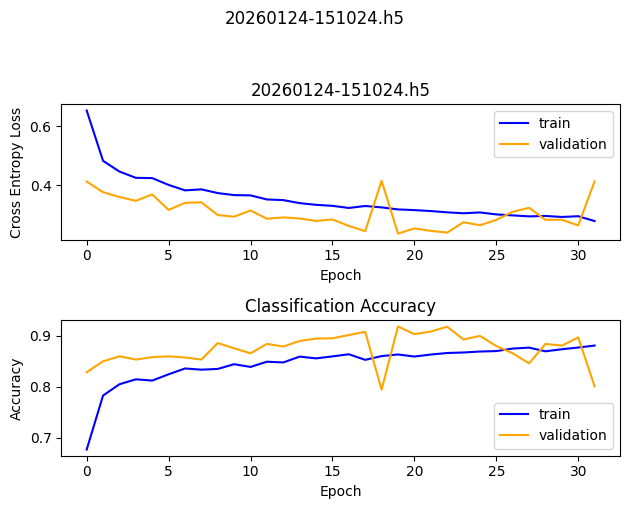

Training finished.
Hold-out test: {'loss': 0.24633030593395233, 'acc': 0.9033263921737671}


In [4]:
import os
import sys
import numpy as np

# Ensure legacy Keras 2 API for pipeline modules
os.environ.setdefault('TF_USE_LEGACY_KERAS', '1')
try:
    import tf_keras
    sys.modules['keras'] = tf_keras
except Exception:
    pass

# Ensure we are in the repo root and the pipeline is importable.
from pathlib import Path

def _find_repo_root():
    here = Path.cwd()
    candidates = [here, *here.parents]
    for name in (
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing',
        'Deep-Learning-and-Single-Cell-Phenotyping-for-Rapid-Antimicrobial-Susceptibility-Testing-main',
    ):
        candidates.append(here / name)
    for p in candidates:
        if (p / 'pipeline' / 'helpers.py').exists():
            return p
    raise FileNotFoundError('Repo root not found (missing pipeline/helpers.py). Re-run the clone cell.')

repo_root = _find_repo_root()
os.chdir(repo_root)
print('Repo root:', repo_root)

pipeline_dir = str(repo_root / 'pipeline')
if pipeline_dir not in sys.path:
    sys.path.insert(0, pipeline_dir)

import importlib
import helpers
import classification
importlib.reload(helpers)
importlib.reload(classification)
from classification import struct_from_file, split_cell_sets, train, cells_from_struct
from datetime import datetime

from pathlib import Path

# Build a real (labeled) single-cell dataset from the downloaded `Zagajewski_Data` (MG1655)
# Section 4 shows this structure exists:
#   ./data/Zagajewski_Data/Data/MG1655/All_images/<COND>/*.tif
#   ./data/Zagajewski_Data/Data/MG1655/All_segmentations/<COND>/*.tif
# We'll turn the integer-encoded segmentation masks into single-cell instance masks, then crop cells and train.

RAW_ROOT = Path('./data/Zagajewski_Data/Data/MG1655')
IMAGES_ROOT = RAW_ROOT / 'All_images'
SEGS_ROOT = RAW_ROOT / 'All_segmentations'
if not (IMAGES_ROOT.exists() and SEGS_ROOT.exists()):
    raise FileNotFoundError('MG1655 data not found under ./data/Zagajewski_Data/Data/MG1655. Run the download/unzip + Section 4 listing first.')

available_conditions = sorted({p.name for p in IMAGES_ROOT.iterdir() if p.is_dir()} & {p.name for p in SEGS_ROOT.iterdir() if p.is_dir()})
print('Available MG1655 conditions:', available_conditions)

# Pick the conditions you want to classify (two-class by default). Edit this list.
COND_IDS = ['WT+ETOH', 'CIP+ETOH']
PATIENT_SPLIT = False  # Set True if using patient-level Train/Val/Test splits
for cond in COND_IDS:
    if cond not in available_conditions:
        raise ValueError(f'Condition {cond!r} not found. Choose from: {available_conditions}')

def _slug(s: str) -> str:
    return ''.join(ch if ch.isalnum() else '_' for ch in s)

# IMPORTANT (leakage): we split by *image* first (Train/Validation/Test), then crop cells inside each split.
# Do not re-split at the single-cell level, otherwise cells from the same microscope image can leak across splits.
TEST_SIZE = 0.10
VAL_SIZE = 0.20  # fraction of the remaining Train+Val pool used for Validation (see implementations.TrainTestVal_split)
DATASET_OUT = Path('./data') / (
    f"classifier_dataset_mg1655_{'__'.join(_slug(c) for c in COND_IDS)}_t{int(TEST_SIZE*100)}_v{int(VAL_SIZE*100)}"
)
OUTPUT_CLASSIFIER_DIR = './models/classification'
os.makedirs(OUTPUT_CLASSIFIER_DIR, exist_ok=True)

import mask_generators
import implementations
importlib.reload(mask_generators)
importlib.reload(implementations)
from mask_generators import masks_from_integer_encoding
from implementations import TrainTestVal_split

# Ensure single-cell instance masks exist for each condition
image_sources = []
annot_sources = []
for cond in COND_IDS:
    img_dir = IMAGES_ROOT / cond
    seg_dir = SEGS_ROOT / cond
    annots_dir = seg_dir / 'annots'

    if not annots_dir.exists() or not any(annots_dir.iterdir()):
        print(f'Generating single-cell masks for {cond}...')
        masks_from_integer_encoding(mask_path=str(seg_dir), output_path=str(seg_dir), combined_convention=False)

    image_sources.append(str(img_dir))
    annot_sources.append(str(annots_dir))

# Create a standard dataset layout (Train/Validation/Test) if needed
train_split = DATASET_OUT / 'Train'
val_split = DATASET_OUT / 'Validation'
test_split = DATASET_OUT / 'Test'
if not ((train_split / 'images').exists() and (train_split / 'annots').exists()):
    print('Creating classification dataset at:', DATASET_OUT)
    TrainTestVal_split(
        data_sources=image_sources,
        annotation_sources=annot_sources,
        output_folder=str(DATASET_OUT),
        test_size=TEST_SIZE,
        validation_size=VAL_SIZE,
        seed=42,
    )

# Sanity check: ensure image-level splits are disjoint
def _image_ids(split_root: Path):
    p = split_root / 'images'
    if not p.exists():
        return set()
    return {f.name for f in p.iterdir() if f.is_file()}

train_ids = _image_ids(train_split)
val_ids = _image_ids(val_split)
test_ids = _image_ids(test_split)
print('Image files (train/val/test):', len(train_ids), len(val_ids), len(test_ids))
overlaps = {
    'train∩val': len(train_ids & val_ids),
    'train∩test': len(train_ids & test_ids),
    'val∩test': len(val_ids & test_ids),
}
print('Overlaps (image-level splits):', overlaps)
HAS_IMAGE_LEVEL_OVERLAP = any(v > 0 for v in overlaps.values())
assert not HAS_IMAGE_LEVEL_OVERLAP, 'Image-level Train/Val/Test splits overlap; this indicates a bug in TrainTestVal_split.'

# Convert folder-of-instance-masks -> cropped single-cell images (streaming; RAM-safe)
#
# IMPORTANT: `struct_from_file(...)` loads *all* masks into RAM and can easily exceed Colab's ~12GB limit.
# This streaming approach only keeps up to `N_PER_CLASS` crops per class in memory.
import re
import gc
import skimage
import skimage.io
from skimage.transform import resize

# Optionally cap the number of cell crops per class to keep system RAM bounded.
# Set to a smaller number (e.g. 200-1000) if you still hit OOM. Set to None to use all cells (can OOM).
N_PER_CLASS = 2000
# Keep this in sync with the model input size below.
CROP_TARGET_SIZE = (64, 64, 3)

def _find_image_path(images_root: Path, annot_folder_name: str) -> Path:
    candidates = [
        images_root / annot_folder_name,
        images_root / (Path(annot_folder_name).stem + '.tif'),
        images_root / (Path(annot_folder_name).stem + '.tiff'),
    ]
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError(f'No image found for annot folder {annot_folder_name!r} under {images_root}')

def _match_cond(name: str, cond_ids: list[str]) -> str | None:
    matches = []
    for cond in cond_ids:
        if re.search(re.escape(cond), name) is not None:
            matches.append(cond)
    return matches[0] if len(matches) == 1 else None

def _crop_cells_streaming(dataset_root: Path, cond_ids: list[str], max_per_class: int | None, seed: int = 42):
    rng_local = np.random.default_rng(seed)
    images_root = dataset_root / 'images'
    annots_root = dataset_root / 'annots'
    if not (images_root.exists() and annots_root.exists()):
        raise FileNotFoundError(f'Expected {images_root} and {annots_root} to exist.')

    out = {'class_id_to_name': []}
    for i, cond in enumerate(cond_ids):
        out[cond] = []
        out['class_id_to_name'].append({'class_id': i, 'name': cond})

    kept = {cond: 0 for cond in cond_ids}
    removed_edge = 0
    skipped_nomatch = 0

    annot_dirs = [p for p in annots_root.iterdir() if p.is_dir()]
    rng_local.shuffle(annot_dirs)

    for annot_dir in annot_dirs:
        cond = _match_cond(annot_dir.name, cond_ids)
        if cond is None:
            skipped_nomatch += 1
            continue
        if max_per_class is not None and kept[cond] >= max_per_class:
            continue

        img_path = _find_image_path(images_root, annot_dir.name)
        image = skimage.io.imread(str(img_path))
        if image.ndim == 2:
            image = image[..., None]

        # Ensure 3 channels for ImageNet backbones (DenseNet/ResNet/VGG).
        if image.shape[-1] == 1:
            image = np.repeat(image, 3, axis=-1)
        elif image.shape[-1] > 3:
            image = image[..., :3]

        sy, sx = image.shape[:2]

        mask_files = [p for p in annot_dir.iterdir() if p.suffix.lower() == '.bmp']
        rng_local.shuffle(mask_files)

        for mask_path in mask_files:
            if max_per_class is not None and kept[cond] >= max_per_class:
                break

            mask = skimage.io.imread(str(mask_path))
            mask = np.asarray(mask)
            if mask.ndim == 3:
                # Some readers return RGB; collapse to a single channel.
                mask = mask.max(axis=-1)
            # Support both 0/1 and 0/255 saved masks.
            mask = mask > 0
            if not mask.any():
                continue

            ys, xs = np.where(mask)
            y1, y2 = int(ys.min()), int(ys.max()) + 1  # y2 exclusive
            x1, x2 = int(xs.min()), int(xs.max()) + 1  # x2 exclusive

            # Mirror `helpers.remove_edge_cells()` semantics (Mask R-CNN rois are exclusive at y2/x2).
            on_edge = (y1 == 0) or (x1 == 0) or (y2 == 0) or (x2 == 0) or (y1 >= sy) or (x1 >= sx) or (y2 >= sy) or (x2 >= sx)
            if on_edge:
                removed_edge += 1
                continue

            roi = mask[y1:y2, x1:x2]
            crop = image[y1:y2, x1:x2, :].copy()
            crop *= roi[..., None]

            # Resize early so every sample is the same (small) size -> much lower RAM.
            crop = resize(crop, CROP_TARGET_SIZE, anti_aliasing=True)
            crop = skimage.img_as_ubyte(crop)
            out[cond].append(crop)
            kept[cond] += 1

        if max_per_class is not None and all(kept[c] >= max_per_class for c in cond_ids):
            break

    return out, removed_edge, skipped_nomatch

# Crop cells separately per split (prevents leakage across Train/Val/Test)
N_PER_CLASS_TRAIN = N_PER_CLASS
N_PER_CLASS_VAL = min(1000, N_PER_CLASS)  # lower by default to save RAM; set to None for all
N_PER_CLASS_TEST = None  # set to an int to cap RAM usage

cells_train, removed_train, skipped_train = _crop_cells_streaming(dataset_root=train_split, cond_ids=COND_IDS, max_per_class=N_PER_CLASS_TRAIN, seed=42)
cells_val, removed_val, skipped_val = _crop_cells_streaming(dataset_root=val_split, cond_ids=COND_IDS, max_per_class=N_PER_CLASS_VAL, seed=43)
cells_test, removed_test, skipped_test = _crop_cells_streaming(dataset_root=test_split, cond_ids=COND_IDS, max_per_class=N_PER_CLASS_TEST, seed=44)

print('Removed edge cells (train/val/test):', removed_train, removed_val, removed_test)
if skipped_train or skipped_val or skipped_test:
    print('WARNING: skipped annotation folders with ambiguous/no cond match:', {'train': skipped_train, 'val': skipped_val, 'test': skipped_test})

for split_name, cells_split in [('train', cells_train), ('val', cells_val), ('test', cells_test)]:
    print('---', split_name, '---')
    for cond in COND_IDS:
        print(cond, 'cells:', len(cells_split[cond]))

def _to_xy(cells_struct):
    X, y = [], []
    for mapping in cells_struct['class_id_to_name']:
        cond = mapping['name']
        cid = int(mapping['class_id'])
        X.extend(cells_struct[cond])
        y.extend([cid] * len(cells_struct[cond]))
    return X, np.asarray(y, dtype='int32')

if PATIENT_SPLIT:
    # Current, non-leaky behaviour: Train/Val/Test are disjoint at the image level,
    # and we keep that separation when training the classifier.
    X_train, y_train = _to_xy(cells_train)
    X_val, y_val = _to_xy(cells_val)
    X_test, y_test = _to_xy(cells_test)
    print('Split sizes (image-level, per-split cropping):', {'train': len(X_train), 'val': len(X_val), 'test': len(X_test)})
    HAS_SPLIT_OVERLAP = False
else:
    # Leaky behaviour (for comparison with the original pipeline):
    # merge all cropped cells across Train/Val/Test and split at the single-cell level.
    # This ignores image-level grouping, so cells from the same image can land in
    # both train and test, which is analogous to the old implementation.
    cells_all = {'class_id_to_name': cells_train['class_id_to_name']}
    for mapping in cells_all['class_id_to_name']:
        cond = mapping['name']
        cells_all[cond] = cells_train[cond] + cells_val[cond] + cells_test[cond]

    TEST_FRACTION = TEST_SIZE
    X_train, X_test, y_train, y_test = split_cell_sets(input=cells_all, test_size=TEST_FRACTION, random_state=42)
    X_val, y_val = None, None
    print('Split sizes (cell-level, leaky):', {'train': len(X_train), 'test': len(X_test)})
    HAS_SPLIT_OVERLAP = True

if any(len(cells_train[c]) == 0 for c in COND_IDS):
    raise ValueError('No cells were extracted for one or more classes in TRAIN. Check masks/images alignment.')
if any(len(cells_val[c]) == 0 for c in COND_IDS):
    print('WARNING: one or more classes have 0 cells in VALIDATION (split may be too small).')
if any(len(cells_test[c]) == 0 for c in COND_IDS):
    print('WARNING: one or more classes have 0 cells in TEST (split may be too small).')

gc.collect()

# Sanity checks: if accuracy is near chance, first confirm the crops look correct.
min_cells = min(len(cells_train[c]) for c in COND_IDS)
if min_cells < 1000:
    print('WARNING: very few cells per class; accuracy will likely be low. Consider using more data (N_PER_CLASS=None) or different conditions.')

import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

def _plot_examples(label, imgs, n=6):
    if not imgs:
        return
    k = min(n, len(imgs))
    idx = rng.choice(len(imgs), size=k, replace=False)
    fig, axs = plt.subplots(1, k, figsize=(2*k, 2))
    fig.suptitle(f'Example cropped cells: {label}')
    if k == 1:
        axs = [axs]
    for ax, i in zip(axs, idx):
        img = imgs[i]
        if getattr(img, 'ndim', 0) == 3 and img.shape[-1] >= 3:
            ax.imshow(img[..., :3])
        else:
            ax.imshow(np.squeeze(img), cmap='gray')
        ax.axis('off')
    plt.show()

for cond in COND_IDS:
    _plot_examples(cond, cells_train[cond], n=6)

def _mean_intensity(imgs, n=200):
    if not imgs:
        return 0.0, 0.0
    k = min(n, len(imgs))
    idx = rng.choice(len(imgs), size=k, replace=False)
    vals = [float(np.asarray(imgs[i]).mean()) for i in idx]
    return float(np.mean(vals)), float(np.std(vals))

for cond in COND_IDS:
    mean_i, std_i = _mean_intensity(cells_train[cond])
    print(f'{cond}: mean intensity ~ {mean_i:.2f} (std {std_i:.2f})')

# `N_PER_CLASS_*` sampling happens above (during streaming collection), to avoid loading the full dataset into RAM.

# Metadata tags used for naming Optuna studies and output folders
COND_TAG = '_'.join(_slug(c) for c in COND_IDS)
SPLIT_MODE_TAG = 'patientSplitOn' if PATIENT_SPLIT else 'patientSplitOff'
OVERLAP_TAG = 'overlap' if HAS_SPLIT_OVERLAP else 'noOverlap'
SPLIT_TAG = f"{SPLIT_MODE_TAG}_{OVERLAP_TAG}"

# Model / training defaults
MODEL_TYPE = 'EfficientNetB0'
INIT_SOURCE = 'imagenet'  # ImageNet pretrained weights
TARGET_SIZE = CROP_TARGET_SIZE
NUM_CLASSES = len(COND_IDS)
BATCH_SIZE = 4
EPOCHS = 100
OPTIMIZER = 'NAdam'

if len(X_train) < BATCH_SIZE:
    raise ValueError(f'Too few training samples ({len(X_train)}) for batch_size={BATCH_SIZE}. Reduce batch_size or increase N_PER_CLASS.')

# Optuna: Bayesian optimization (TPE sampler) + pruning
DO_OPTUNA = True
N_TRIALS = 25
EPOCHS_TUNE = 40

best_params = None
if DO_OPTUNA:
    import optuna

    tune_dt = datetime.now().strftime('%Y%m%d-%H%M%S')
    tune_name = f"optuna_{MODEL_TYPE}_{COND_TAG}_{SPLIT_TAG}_{tune_dt}"
    TUNE_DIR = os.path.join(OUTPUT_CLASSIFIER_DIR, tune_name)
    os.makedirs(TUNE_DIR, exist_ok=True)
    print('Starting Optuna study. Base dir:', TUNE_DIR)

    sampler = optuna.samplers.TPESampler(seed=42, multivariate=True)
    pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
    study_storage_url = f"sqlite:///{os.path.join(TUNE_DIR, 'optuna_study.db')}"
    study = optuna.create_study(
        direction='maximize',
        sampler=sampler,
        pruner=pruner,
        study_name=tune_name,
        storage=study_storage_url,
        load_if_exists=True,
    )

    def objective(trial):
        dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.6)
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 3e-3, log=True)
        patience = trial.suggest_int('patience', 3, 12)

        trial_dt = f"trial_{trial.number:03d}"
        trial_logdir = os.path.join(TUNE_DIR, trial_dt)
        os.makedirs(trial_logdir, exist_ok=True)

        return train(
            mode=MODEL_TYPE,
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            size_target=TARGET_SIZE,
            class_count=NUM_CLASSES,
            logdir=trial_logdir,
            verbose=False,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS_TUNE,
            learning_rate=learning_rate,
            optimizer=OPTIMIZER,
            init_source=INIT_SOURCE,
            dropout_rate=dropout_rate,
            early_stopping_patience=patience,
            use_lr_scheduler=False,
            plot_diagnostics=False,
            val_seed=42,
            trial=trial,
            prune_monitor='val_accuracy',
            return_best=True,
            return_best_monitor='val_accuracy',
            pad_cells=False,
        )

    study.optimize(objective, n_trials=N_TRIALS)
    # Persist Optuna study to disk for later analysis / reuse
    import pickle

    try:
        df = study.trials_dataframe()
        df.to_csv(os.path.join(TUNE_DIR, 'trials.csv'), index=False)
    except Exception as e:
        print('WARNING: failed to save Optuna trials dataframe:', e)

    try:
        with open(os.path.join(TUNE_DIR, 'study.pkl'), 'wb') as f:
            pickle.dump(study, f)
    except Exception as e:
        print('WARNING: failed to pickle Optuna study:', e)

    print('Best trial:', study.best_trial.number)
    print('Best params:', study.best_trial.params)
    best_params = study.best_trial.params
else:
    best_params = {'dropout_rate': 0.2, 'learning_rate': 3e-4, 'patience': 8}

LEARNING_RATE = float(best_params['learning_rate'])
DROPOUT = float(best_params['dropout_rate'])
PATIENCE = int(best_params['patience'])

dt_string = datetime.now().strftime('%Y%m%d-%H%M%S')
run_name = f"{MODEL_TYPE}_{COND_TAG}_{SPLIT_TAG}_{dt_string}"
LOG_DIR = os.path.join(OUTPUT_CLASSIFIER_DIR, run_name)
os.makedirs(LOG_DIR, exist_ok=True)
print('Starting final classification training. Log dir:', LOG_DIR)
print('Params:', {'lr': LEARNING_RATE, 'dropout': DROPOUT, 'patience': PATIENCE})

train(
    mode=MODEL_TYPE,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    X_test=X_test,
    y_test=y_test,
    eval_test_each_epoch=True,
    size_target=TARGET_SIZE,
    class_count=NUM_CLASSES,
    logdir=LOG_DIR,
    verbose=False,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    optimizer=OPTIMIZER,
    init_source=INIT_SOURCE,
    dropout_rate=DROPOUT,
    early_stopping_patience=PATIENCE,
    use_lr_scheduler=False,
    val_seed=42,
    dt_string=dt_string,
    pad_cells=False,
)

print('Training finished.')

# Hold-out test evaluation (10%)
from keras.models import load_model
from keras.utils import to_categorical
import skimage
from imgaug import augmenters as iaa

model_path = os.path.join(LOG_DIR, dt_string + '.h5')
model = load_model(model_path)
X_test_arr = skimage.img_as_ubyte(np.asarray(X_test))
histeq_aug = iaa.Sequential([iaa.AllChannelsHistogramEqualization()])
X_test_arr = histeq_aug(images=X_test_arr)
try:
    from keras.applications.efficientnet import preprocess_input as _eff_preprocess_input
    X_test_arr = _eff_preprocess_input(X_test_arr.astype(np.float32))
except Exception:
    try:
        from tensorflow.keras.applications.efficientnet import preprocess_input as _eff_preprocess_input
        X_test_arr = _eff_preprocess_input(X_test_arr.astype(np.float32))
    except Exception:
        X_test_arr = X_test_arr.astype(np.float32)

y_test_cat = to_categorical(np.asarray(y_test, dtype='int32'), NUM_CLASSES)
test_loss, test_acc = model.evaluate(X_test_arr, y_test_cat, verbose=0)
print('Hold-out test:', {'loss': float(test_loss), 'acc': float(test_acc)})

In [7]:
import os, pickle

# Save full trial history
df = study.trials_dataframe()
df.to_csv(os.path.join(TUNE_DIR, "trials.csv"), index=False)

# Save the entire Study object
with open(os.path.join(TUNE_DIR, "study.pkl"), "wb") as f:
    pickle.dump(study, f)
print('Optuna study and trials saved to:', TUNE_DIR)


Optuna study and trials saved to: ./models/classification/optuna_EfficientNetB0_WT_ETOH_CIP_ETOH_20260122-213549


## 7. Next Steps

After successful training, your model weights (`.h5` files) will be saved in the specified output directories (e.g., `./models/segmentation` and `./models/classification`).

You can then use these `.h5` files in your `web_app/app.py` to integrate the deep learning pipeline with your web application.

In [ ]:
# Helper utilities: load and visualize Optuna studies from saved tuning directories
import os


def load_optuna_study_from_dir(tune_dir, study_name=None):
    """Load an Optuna Study from a tuning directory.

    Priority:
      1) study.pkl (pickle of the Study object)
      2) optuna_study.db (SQLite storage created in Section 6)
    """
    import pickle
    import optuna

    tune_dir = os.path.abspath(os.path.expanduser(str(tune_dir)))
    if not os.path.isdir(tune_dir):
        raise FileNotFoundError(f"Tuning directory not found: {tune_dir!r}")

    pkl_path = os.path.join(tune_dir, 'study.pkl')
    if os.path.exists(pkl_path):
        with open(pkl_path, 'rb') as f:
            study = pickle.load(f)
        return study

    db_path = os.path.join(tune_dir, 'optuna_study.db')
    if os.path.exists(db_path):
        if study_name is None:
            study_name = os.path.basename(os.path.normpath(tune_dir))
        storage_url = f"sqlite:///{db_path}"
        return optuna.load_study(study_name=study_name, storage=storage_url)

    raise FileNotFoundError(
        f"No Optuna study artifacts found in {tune_dir!r} (expected 'study.pkl' or 'optuna_study.db')."
    )


def plot_optuna_diagnostics(tune_dir=None, study=None):
    """Plot optimization history and hyperparameter importance for a saved Optuna study.

    Either provide a `tune_dir` (path to a tuning directory created in Section 6)
    or an already loaded `study` object.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    if study is None:
        if tune_dir is None:
            raise ValueError("Provide either `tune_dir` or `study`.")
        study = load_optuna_study_from_dir(tune_dir)

    try:
        df = study.trials_dataframe()
    except Exception as e:
        print("Failed to build trials dataframe from study:", e)
        return

    if df.empty:
        print("Study has no trials.")
        return

    # Only use completed trials for plotting objective values
    df_complete = df[df['state'] == 'COMPLETE']
    if df_complete.empty:
        print("Study has no completed trials to plot.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Optimization history
    axes[0].plot(df_complete['number'], df_complete['value'], 'o-')
    axes[0].set_xlabel('Trial number')
    axes[0].set_ylabel('Objective value')
    axes[0].set_title('Optuna optimization history')

    # Hyperparameter importance (Optuna's built-in importance analysis)
    try:
        from optuna.importance import get_param_importances

        importances = get_param_importances(study)
        if not importances:
            axes[1].text(0.5, 0.5, 'No hyperparameters to rank.', ha='center', va='center')
            axes[1].axis('off')
        else:
            names = list(importances.keys())
            vals = [float(importances[n]) for n in names]
            x = np.arange(len(names))
            axes[1].bar(x, vals)
            axes[1].set_xticks(x)
            axes[1].set_xticklabels(names, rotation=45, ha='right')
            axes[1].set_ylabel('Importance')
            axes[1].set_title('Hyperparameter importance (Optuna)')
    except Exception as e:
        axes[1].text(
            0.5,
            0.5,
            f'Failed to compute parameter importance:
{e}',
            ha='center',
            va='center',
        )
        axes[1].axis('off')

    fig.tight_layout()
    plt.show()


def find_latest_optuna_dir(base_dir='./models/classification'):
    """Return the most recent optuna_* directory under `base_dir`.

    Useful when the kernel has been restarted and `TUNE_DIR` is no longer in memory.
    """
    base_dir = os.path.abspath(os.path.expanduser(str(base_dir)))
    if not os.path.isdir(base_dir):
        raise FileNotFoundError(f"Base directory not found: {base_dir!r}")

    candidates = []
    for name in os.listdir(base_dir):
        path = os.path.join(base_dir, name)
        if os.path.isdir(path) and name.startswith('optuna_'):
            candidates.append(path)

    if not candidates:
        raise FileNotFoundError(f"No optuna_* tuning directories found under {base_dir!r}.")

    # Sort by name (timestamps are at the end of the name) and take the last one
    candidates.sort()
    return candidates[-1]


# Example usage (run in a separate cell or uncomment):
#
# 1) From the most recent Optuna run on disk:
# latest_dir = find_latest_optuna_dir()
# print('Latest tuning directory:', latest_dir)
# plot_optuna_diagnostics(tune_dir=latest_dir)
#
# 2) From the current session's study/TUNE_DIR (after running Section 6):
# plot_optuna_diagnostics(tune_dir=TUNE_DIR)
